*Antonio Coín Castro*     


# Bayesian Functional Linear Regression

In [1]:
# -- Libraries

from matplotlib import pyplot as plt
import arviz as az
import numpy as np
from sklearn.svm import SVR
import pandas as pd
from IPython.display import display
import logging
import skfda
import os
from skfda.preprocessing.dim_reduction.feature_extraction import FPCA
from skfda.ml.regression import KNeighborsRegressor
from skfda.ml.regression import LinearRegression as FLinearRegression
from skfda.representation.basis import FDataBasis, Monomial, Fourier
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.exceptions import ConvergenceWarning
import sys
import pickle
import scipy
from multiprocessing import Pool
import utils
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

In [2]:
# -- Configuration

# Extensions
%load_ext autoreload
%autoreload 2

# Plotting configuration
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [6, 4]
plt.style.use('arviz-darkgrid')
NCOLS = 3


def NROWS(x, ncols=NCOLS):
    return np.ceil(x/ncols).astype('int')


# Randomness and reproducibility
SEED = 42
np.random.seed(SEED)
rng = np.random.default_rng(SEED)

# Floating point precision for display
np.set_printoptions(precision=3, suppress=True)
pd.set_option("display.precision", 3)

# Multiprocessing
N_CORES = 4

# Ignore warnings
os.environ["PYTHONWARNINGS"] = 'ignore::UserWarning'

We consider the model

$$
Y_i = \alpha_0 + \Psi^{-1}_{X_i}(\alpha) + \varepsilon_i,
$$

i.e.,

$$
Y_i \sim \mathcal N\left(\alpha_0 + \sum_{j=1}^p \beta_jX_i(\tau_j), \ \sigma^2\right).
$$

The prior distributions we choose are:

\begin{align*}
  \pi(\alpha_0, \sigma^2)              & \propto 1/\sigma^2,                                                     \\
  \tau                     & \sim \mathscr U([0, 1]^p),                                              \\
  \beta\mid \tau, \sigma^2 & \sim \mathcal N\left(b_0, g\sigma^2\left[\mathcal X_\tau' \mathcal X_\tau + \eta \lambda_{\text{max}}(\mathcal X_\tau' \mathcal X_\tau)\right]^{-1}\right),
\end{align*}

Writing the parameter vector as $\theta = (\beta, \tau, \alpha_0, \sigma^2)$, the joint posterior probability is:

$$
\pi(\beta, \tau, \alpha_0, \sigma^2\mid Y) \propto \frac{|G_\tau|^{1/2}}{\sigma^{p+n+2}} \exp\left\{ -\frac{1}{2\sigma^2} \left(\|Y- \alpha_0\boldsymbol{1} - \mathcal X_\tau\beta\|^2 + \frac{1}{g}(\beta - b_0)'G_\tau(\beta - b_0) \right) \right\}.
$$

Hence, the log-posterior probability is:

$$
\log \pi(\beta, \tau, \alpha_0, \sigma^2\mid Y) \propto \frac{1}{2}\log |G_\tau| - (p+n+2)\log \sigma -\frac{1}{2\sigma^2} \left(\|Y-\alpha_0\boldsymbol{1} - \mathcal X_\tau\beta\|^2 + \frac{1}{g}(\beta - b_0)'G_\tau(\beta - b_0) \right).  
$$

Note that for computational reasons we will work with $\log \sigma$ instead of $\sigma^2$, and hence the associated prior distribution is

$$
\pi(\alpha_0, \log\sigma) \propto 1.
$$

The metrics considered for model evaluation will be:

- RMSE.
- $R^2$.

## Example dataset

We generate a toy dataset with $n=100$ functional regressors $X_i(t) \sim GP(0, K(s, t))$, a response variable given by either a $L^2$ model or a "simple" RKHS function, a value of $\alpha_0=5$ and a variance of $\sigma^2=0.5$. More precisely, we choose one of

$$
Y_i \sim \mathcal N\big(5 -5X_i(0.1) + 10X_i(0.8), \ 0.5\big)
$$

or

$$
Y_i \sim \mathcal N\left(5 + \int_0^1 \beta(t)X_i(t)\, dt, \ 0.5\right),
$$

where $\beta(t) \in L^2[0, 1]$.

We consider a regular grid of $N=100$ points on $[0, 1]$. In addition, we center the $X_i$ so that they have zero mean when fed to the sampling algorithms.

We also generate a test dataset with $n_{\text{test}}=50$ regressors for model evaluation.

In [55]:
# -- Data generation parameters

SYNTHETIC_DATA = False
MODEL_GEN = "L2"    # 'L2' or 'RKHS'
kernel_fn = utils.fractional_brownian_kernel
beta_coef = utils.cholaquidis_scenario3

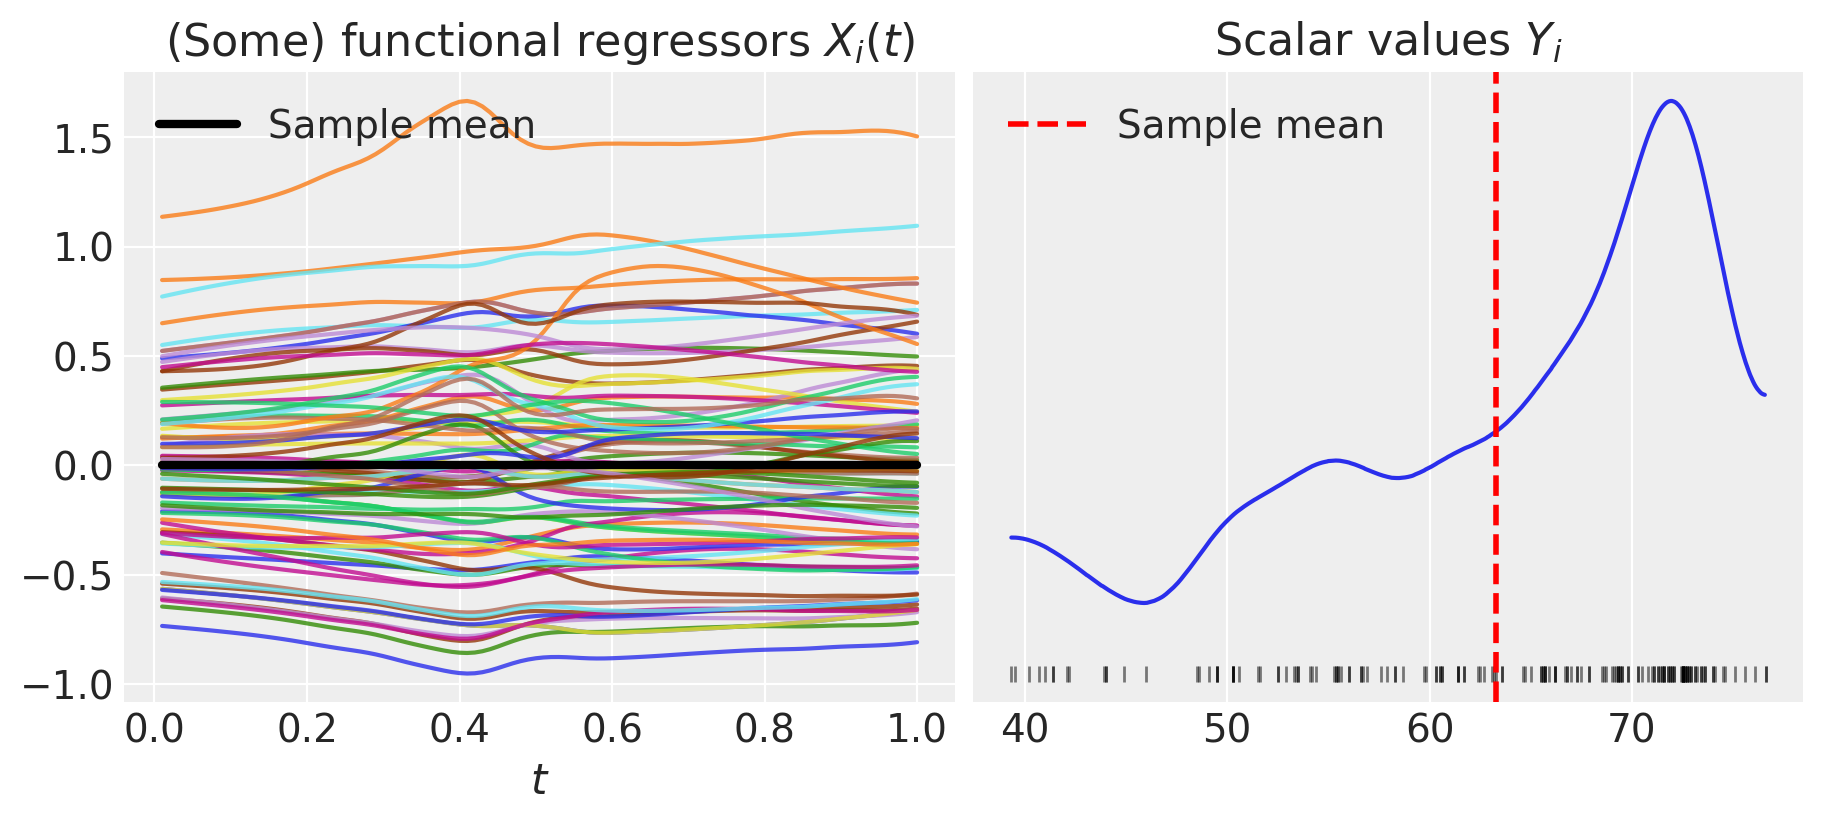

In [56]:
# -- Dataset generation

if SYNTHETIC_DATA:
    n_train, n_test = 100, 50
    N = 100
    grid = np.linspace(1./N, 1., N)

    beta_true = np.array([-5., 10.])
    tau_true = np.array([0.1, 0.8])
    alpha0_true = 5.
    sigma2_true = 0.5

    if MODEL_GEN == "L2":
        X, Y = utils.generate_gp_l2_dataset(
            grid, kernel_fn,
            n_train, beta_coef, alpha0_true,
            sigma2_true, rng=rng
        )

        X_test, Y_test = utils.generate_gp_l2_dataset(
            grid, kernel_fn,
            n_test, beta_coef, alpha0_true,
            sigma2_true, rng=rng
        )

    else:
        X, Y = utils.generate_gp_rkhs_dataset(
            grid, kernel_fn,
            n_train, beta_true, tau_true,
            alpha0_true, sigma2_true, rng=rng
        )

        X_test, Y_test = utils.generate_gp_rkhs_dataset(
            grid, kernel_fn,
            n_test, beta_true, tau_true,
            alpha0_true, sigma2_true, rng=rng
        )

    # Create FData object
    X_fd = skfda.FDataGrid(X, grid)
    X_test_fd = skfda.FDataGrid(X_test, grid)

else:
    X_tecator, Y_tecator = skfda.datasets.fetch_tecator(return_X_y=True)
    Y_tecator = Y_tecator[:, 1]  # Fat percentage

    X_fd, X_test_fd, Y, Y_test = train_test_split(
        X_tecator, Y_tecator, train_size=0.8, random_state=SEED)

    N = len(X_fd.grid_points[0])
    grid = np.linspace(1./N, 1., N)  # TODO: use (normalized) real grid
    n_train, n_test = len(X_fd.data_matrix), len(X_test_fd.data_matrix)

# Standardize data
X_m = X_fd.mean(axis=0)
X_fd = X_fd - X_m
X = X_fd.data_matrix.reshape(-1, N)
X_test_fd = X_test_fd - X_m
X_test = X_test_fd.data_matrix.reshape(-1, N)

utils.plot_dataset(X, Y)

## Common model hyperparameters

In our algorithms, we consider an unconstrained tranformed parameter space $\tilde \Theta=\mathbb{R}^{2\hat p+2}$ via the bijections

- $\tau_j \mapsto \operatorname{logit}(\tau_j)$.
- $\sigma^2 \mapsto \log\sigma$.

In [68]:
# -- Model hyperparameters

p_hat = 4
TRANSFORM_TAU = False

In [69]:
# -- Names and labels

# Names of parameters
theta_names = ["β", "τ", "α0", "σ2"]
if TRANSFORM_TAU:
    theta_names_ttr = ["β", "logit τ", "α0", "log σ"]
else:
    theta_names_ttr = ["β", "τ", "α0", "log σ"]
theta_names_aux = ["α0 and log σ"]

# Grouped labels
theta_labels_grouped = [r"$\beta$", r"$\tau$", r"$\alpha_0$", r"$\sigma^2$"]

# Individual labels
theta_labels = []
for i in range(p_hat):
    theta_labels.append(fr"$\beta_{i + 1}$")
for i in range(p_hat):
    theta_labels.append(fr"$\tau_{i + 1}$")
theta_labels.append(theta_labels_grouped[-2])
theta_labels.append(theta_labels_grouped[-1])

# Labels for Arviz
theta_labeller = az.labels.MapLabeller(
    var_name_map=dict(zip(theta_names[-2:], theta_labels_grouped[-2:])),
    coord_map={"projection": dict(
        zip(np.arange(p_hat), np.arange(1, p_hat + 1)))}
)

# Dimension of parameter vector
theta_ndim = len(theta_labels)

# Dimension of grouped parameter vector
theta_ndim_grouped = len(theta_names)

# Names of results columns
results_columns = ["Estimator", "Features", "MSE", "RMSE", r"$R^2$"]

In [70]:
# -- Object representing parameter space

if TRANSFORM_TAU:
    tau_ttr = utils.Logit()
else:
    tau_ttr = utils.Identity()

theta_space = utils.ThetaSpace(
    p_hat, grid, theta_names, theta_names_ttr, theta_labels, tau_ttr=tau_ttr)

## Sklearn model comparison

Currently there is a bug when trying to fit an already fitted FPCA object. It checks "if not self.weights" when it should be checking "if self.weights is None" (weights is an ndarray).

In [8]:
# -- Custom transformers

class FeatureSelector(BaseEstimator, TransformerMixin):

    def __init__(self, p=1):
        self.p = p

    def fit(self, X, y=None):
        N = X.shape[1]
        self.idx_ = np.linspace(0, N - 1, self.p).astype(int)
        return self

    def transform(self, X, y=None):
        return X[:, self.idx_]


class DataMatrix(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        self.N = len(X.grid_points[0])
        return self

    def transform(self, X, y=None):
        return X.data_matrix.reshape(-1, self.N)


class Basis(BaseEstimator, TransformerMixin):

    def __init__(self, basis=Fourier()):
        self.basis = basis

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X.to_basis(self.basis)

In [9]:
# -- Select family of regressors

regressors = []
folds = KFold(shuffle=True, random_state=SEED)

alphas = np.logspace(-4, 4, 20)
n_selected = [5, 10, 15, 20, 25]
n_components = [2, 3, 4, 5, 6, 10]
n_basis = [3, 5, 7, 9, 11]
basis_fourier = [Fourier(n_basis=p) for p in n_basis]
n_neighbors = [3, 5, 7]

params_reg = {"reg__alpha": alphas}
params_svm = {"reg__C": alphas, 
              "reg__gamma": ['auto', 'scale']}
params_select = {"selector__p": n_selected}
params_fpca = {"dim_red__n_components": n_components}
params_basis = {"basis__basis": basis_fourier}
params_knn = {"reg__n_neighbors": n_neighbors,
              "reg__weights": ['uniform', 'distance']}

# Lasso
regressors.append(("sk_lasso",
                   Pipeline([
                       ("data_matrix", DataMatrix()),
                       ("reg", Lasso())]),
                   params_reg
                   ))

# Ridge
regressors.append(("sk_ridge",
                   Pipeline([
                       ("data_matrix", DataMatrix()),
                       ("reg", Ridge())]),
                   params_reg
                   ))

# Ridge+manual
regressors.append(("manual_sel+sk_ridge",
                   Pipeline([
                       ("data_matrix", DataMatrix()),
                       ("selector", FeatureSelector()),
                       ("reg", Ridge())]),
                   {**params_reg, **params_select}
                   ))

# FPCA+Lin
regressors.append(("fpca+sk_lin",
                   Pipeline([
                       ("dim_red", FPCA()),  # Retains scores only
                       ("reg", LinearRegression())]),
                   params_fpca
                   ))

# FPCA+Ridge
regressors.append(("fpca+sk_ridge",
                   Pipeline([
                       ("dim_red", FPCA()),  # Retains scores only
                       ("reg", Ridge())]),
                   {**params_fpca, **params_reg}
                   ))

# FPCA+SVM RBF
regressors.append(("fpca+sk_svm_rbf",
                   Pipeline([
                       ("dim_red", FPCA()),  # Retains scores only
                       ("reg", SVR(kernel='rbf'))]),
                   {**params_fpca, **params_svm}
                   ))

# SVM RBF+manual
regressors.append(("manual_sel+sk_svm_rbf",
                   Pipeline([
                       ("data_matrix", DataMatrix()),
                       ("selector", FeatureSelector()),
                       ("reg", SVR(kernel='rbf'))]),
                   {**params_select, **params_svm}
                   ))

# Functional Linear Regression
regressors.append(("sk_flin",
                   Pipeline([
                       ("basis", Basis()),
                       ("reg", FLinearRegression())]),
                   params_basis
                   ))

# KNeighbors Functional Regression
regressors.append(("sk_fknn",
                   Pipeline([
                       ("reg", KNeighborsRegressor())]),
                   params_knn
                   ))

In [10]:
# -- Fit models and show metrics

df_metrics_sk = pd.DataFrame(columns=results_columns)

for i, (name, pipe, params) in enumerate(regressors):
    reg_cv = GridSearchCV(pipe, params, scoring="neg_mean_squared_error",
                          n_jobs=N_CORES, cv=folds)
    reg_cv.fit(X_fd, Y)
    Y_hat = reg_cv.predict(X_test_fd)
    metrics = utils.regression_metrics(Y_test, Y_hat)

    if name == "sk_fknn":
        n_features = f"K={reg_cv.best_params_['reg__n_neighbors']}"

    elif "svm" in name:
        n_features = reg_cv.best_estimator_["reg"].n_features_in_
    else:
        if isinstance(reg_cv.best_estimator_["reg"].coef_[0], FDataBasis):
            coef = reg_cv.best_estimator_["reg"].coef_[0].coefficients[0]
        else:
            coef = reg_cv.best_estimator_["reg"].coef_

        n_features = sum(~np.isclose(coef, 0))

    df_metrics_sk.loc[i] = [
        name,
        n_features,
        metrics["mse"],
        np.sqrt(metrics["mse"]),
        metrics["r2"]]

df_metrics_sk.sort_values(results_columns[-2], inplace=True)
df_metrics_sk.style.hide_index()

 /home/antcc/MCD/TFM/bayesian-functional-regression/venv-bfr-py39/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning:Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.410e+03, tolerance: 1.652e+00


## Maximum Likelihood Estimator

In [71]:
# -- Negative log-likelihood definition in transformed parameter space

def neg_ll(theta_tr, X, Y, theta_space):
    """Transformed parameter vector 'theta_tr' is (β, τ, α0, log σ)."""

    n, N = X.shape
    grid = np.linspace(1./N, 1., N)

    assert len(theta_tr) == theta_space.ndim

    theta = theta_space.backward(theta_tr)
    beta, tau, alpha0, sigma2 = theta_space.get_params(theta)
    log_sigma = theta_space.get_sigma2(theta_tr)

    idx = np.abs(grid - tau[:, np.newaxis]).argmin(1)
    X_tau = X[:, idx]

    return -(-n*log_sigma
             - np.linalg.norm(Y - alpha0 - X_tau@beta)**2/(2*sigma2))

In [72]:
# -- MLE estimation

method_mle = 'L-BFGS-B'  # 'Nelder-Mead', 'Powell' or 'L-BFGS-B'
strategy_mle = 'global'

theta_init = theta_space.forward(
    np.array([0.0]*p_hat + [0.5]*p_hat + [Y.mean()] + [1.0]))

if TRANSFORM_TAU:
    bounds = None
else:
    bounds = ([(None, None)]*p_hat
              + [(theta_space.tau_lb, theta_space.tau_ub)]*p_hat
              + [(None, None)]
              + [(None, None)])

if strategy_mle == 'local':
    mle = scipy.optimize.minimize(
        neg_ll,
        x0=theta_init,
        bounds=bounds,
        method=method_mle,
        args=(X, Y, theta_space)
    )
elif strategy_mle == 'global':
    mle = scipy.optimize.basinhopping(
        neg_ll,
        x0=theta_init,
        seed=rng,
        minimizer_kwargs={"args": (X, Y, theta_space),
                          "method": method_mle,
                          "bounds": bounds}
    )
else:
    raise ValueError('Invalid strategy for MLE computation.')

mle_theta_tr = mle.x
mle_theta = theta_space.backward(mle_theta_tr)
bic = (theta_space.ndim*np.log(n_train)
       + 2*neg_ll(mle_theta_tr, X, Y, theta_space))

print(f"BIC: {bic:.3f}")
pd.DataFrame(zip(theta_space.labels, mle_theta),
             columns=["", "MLE"]).style.hide_index()

BIC: 562.495


## The Ensemble Sampler and the *emcee* library

In [13]:
import emcee

### Model

We only need to provide the sampler with the logarithm of the posterior distribution. For clarity we split up its computation in log-prior and log-likelihood, although for a more efficient implementation it should all be in one function. 

In [14]:
# -- Log-posterior model

def log_prior(theta_tr):
    """Global parameters (for efficient parallelization): 
        X, b0, g, eta, theta_space"""
    assert len(theta_tr) == theta_space.ndim

    n, N = X.shape
    p = theta_space.p
    grid = theta_space.grid

    theta = theta_space.backward(theta_tr)
    beta, tau, alpha0, sigma2 = theta_space.get_params(theta)
    log_sigma = theta_space.get_sigma2(theta_tr)

    if not TRANSFORM_TAU:
        if (tau < theta_space.tau_lb).any() or (tau > theta_space.tau_ub).any():
            return -np.inf

    # Transform variables
    b = beta - b0

    # Compute and regularize G_tau
    idx = np.abs(grid - tau[:, np.newaxis]).argmin(1)
    X_tau = X[:, idx]
    G_tau = X_tau.T@X_tau
    G_tau = (G_tau + G_tau.T)/2.  # Enforce symmetry
    G_tau_reg = G_tau + eta * \
        np.max(np.linalg.eigvalsh(G_tau))*np.identity(p)

    # Compute log-prior
    log_prior = (0.5*utils.logdet(G_tau_reg)
                 - (p + 2)*log_sigma
                 - b.T@G_tau_reg@b/(2*g*sigma2))

    return log_prior


def log_likelihood(theta_tr, Y):
    """Global parameters (for efficient parallelization): X"""
    return -neg_ll(theta_tr, X, Y, theta_space)


def log_posterior(theta_tr, Y):
    """Global parameters (for efficient parallelization): X, rng, return_pps"""
    lp = log_prior(theta_tr)

    if not np.isfinite(lp):
        if return_pps:
            return -np.inf, np.full_like(Y, -np.inf)
        else:
            return -np.inf

    ll = log_likelihood(theta_tr, Y)
    lpos = lp + ll

    if return_pps:
        theta = theta_space.backward(theta_tr)
        pps = utils.generate_response(X, theta, rng=rng)
        return lpos, pps
    else:
        return lpos

### Experiments

We set up the initial points of the chains to be in a random neighbourhood around the MLE to increase the speed of convergence.

In [15]:
def run_emcee(n_walkers, n_iter_initial, n_iter, thin, return_pps):
    # -- Run sampler

    with Pool(N_CORES) as pool:
        print(
            f"-- Running affine-invariant ensemble sampler with {N_CORES} cores --")

        sampler = emcee.EnsembleSampler(
            n_walkers, theta_ndim, log_posterior, pool=pool, args=(Y,))

        print("Tuning phase...")
        state = sampler.run_mcmc(
            p0, n_iter_initial, progress='notebook',
            store=False)
        sampler.reset()

        print("MCMC sampling...")
        sampler.run_mcmc(state, n_iter, progress='notebook')

    print(
        f"Mean acceptance fraction: {100*np.mean(sampler.acceptance_fraction):.3f}%")

    logging.disable(sys.maxsize)  # Disable logger

    # Analyze autocorrelation and set burn-in and thinning values
    autocorr = sampler.get_autocorr_time(quiet=True)
    max_autocorr = np.max(autocorr)
    if (np.isfinite(autocorr)).all():
        burn = int(3*max_autocorr)
    else:
        print("Some autocorrelation value is not finite")
        burn = 500

    logging.disable(logging.NOTSET)  # Re-enable logger

    # Get InferenceData object
    idata_emcee = utils.emcee_to_idata(
        sampler, theta_space, burn, thin, return_pps)

    print("\n-- Summary statistics --")
    display(utils.summary(idata_emcee, var_names=theta_names,
                          kind="stats", labeller=theta_labeller))

    # -- Compute metrics using several point estimates

    point_estimates = ["mode", "mean", "median"]

    df_metrics_emcee = pd.DataFrame(columns=results_columns)

    for i, pe in enumerate(point_estimates):
        Y_hat = utils.point_predict(
            X_test, idata_emcee,
            theta_names, pe)
        metrics = utils.regression_metrics(Y_test, Y_hat)
        df_metrics_emcee.loc[i] = [
            "emcee_" + pe,
            p_hat,
            metrics["mse"],
            np.sqrt(metrics["mse"]),
            metrics["r2"]
        ]

    df_metrics_emcee = df_metrics_emcee.append(df_metrics_sk)
    df_metrics_emcee.sort_values(results_columns[-2], inplace=True)
    print("-- Regression metrics --")
    display(df_metrics_emcee)

    return sampler, idata_emcee

In [16]:
# -- Sampler parameters

g = 5
eta = 0.1

n_walkers = 64
n_iter_initial = 100
n_iter = 1000
return_pps = True
frac_random = 0.2

sd_beta_init = 5.0
sd_tau_init = 0.1
mean_alpha0_init = Y.mean()
sd_alpha0_init = 1.0
param_sigma2_init = 1.  # shape parameter in inv_gamma distribution
sd_sigma2_init = 1.0

FAST_RUN = True

# Start every walker in a (random) neighbourhood around the MLE
p0 = utils.weighted_initial_guess_around_value(
    theta_space, mle_theta_tr, sd_beta_init, sd_tau_init,
    mean_alpha0_init, sd_alpha0_init, param_sigma2_init,
    sd_sigma2_init, n_walkers=n_walkers, rng=rng,
    frac_random=frac_random)

b0 = mle_theta_tr[theta_space.beta_idx]

In [17]:
# -- Run sampler

if FAST_RUN:
    sampler, idata_emcee = run_emcee(
        n_walkers, n_iter_initial, n_iter, 1, return_pps)
else:
    with Pool(N_CORES) as pool:
        print(
            f"-- Running affine-invariant ensemble sampler with {N_CORES} cores --")

        sampler = emcee.EnsembleSampler(
            n_walkers, theta_ndim, log_posterior, pool=pool, args=(Y,))

        print("Tuning phase...")
        state = sampler.run_mcmc(
            p0, n_iter_initial, progress='notebook',
            store=False)
        sampler.reset()

        print("MCMC sampling...")
        sampler.run_mcmc(state, n_iter, progress='notebook')

    print(
        f"Mean acceptance fraction: {100*np.mean(sampler.acceptance_fraction):.3f}%")

-- Running affine-invariant ensemble sampler with 4 cores --
Tuning phase...


  0%|          | 0/100 [00:00<?, ?it/s]

MCMC sampling...


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean acceptance fraction: 10.370%

-- Summary statistics --


mean     sd    hdi_3%   hdi_97%      mode    median
β[1]         -49.469  1.101   -51.235   -47.451   -50.359   -49.556
β[2]         120.857  0.712   119.088   121.950   120.873   120.875
β[3]        4661.181  1.407  4658.946  4663.442  4661.604  4661.111
β[4]         576.497  1.076   574.685   577.837   576.509   576.488
β[5]         -71.486  0.796   -72.810   -70.082   -71.829   -71.614
β[6]       -1449.800  1.208 -1451.785 -1447.993 -1449.475 -1449.608
β[7]       -3856.116  1.764 -3859.246 -3853.991 -3855.124 -3855.939
β[8]          68.677  1.017    67.077    70.250    68.744    68.621
τ[1]           0.216  0.053     0.146     0.323     0.182     0.202
τ[2]           0.982  0.017     0.965     1.000     0.999     0.986
τ[3]           0.746  0.013     0.735     0.765     0.742     0.742
τ[4]           0.613  0.042     0.581     0.666     0.588     0.592
τ[5]           0.423  0.025     0.391     0.437     0.424     0.421
τ[6]           0.817  0.017     0.812     0.835     0.824     0.820
τ[7]           0.711  0.016     0.695     0.736     0.703     0.704
τ[8]           0.210  0.018     0.171     0.238     0.216     0.214
$\alpha_0$    63.258  0.245    62.890    63.789    63.143    63.239
$\sigma^2$     4.911  0.225     4.558     5.384     4.878     4.884

-- Regression metrics --


Estimator Features     MSE   RMSE  $R^2$
5        fpca+sk_svm_rbf        6   4.415  2.101  0.957
6  manual_sel+sk_svm_rbf       25   4.912  2.216  0.953
2    manual_sel+sk_ridge       25   6.342  2.518  0.939
7                sk_flin        7   6.761  2.600  0.935
4          fpca+sk_ridge       10   6.947  2.636  0.933
3            fpca+sk_lin        6   7.295  2.701  0.930
1               sk_ridge      100   7.375  2.716  0.929
0               sk_lasso       61   9.335  3.055  0.910
0             emcee_mode        8  10.149  3.186  0.902
2           emcee_median        8  10.811  3.288  0.896
1             emcee_mean        8  21.649  4.653  0.791
8                sk_fknn      K=3  45.099  6.716  0.565

### Analysis

We analyze the samples of all chains, discarding a few times the integrated autocorrelation times worth of samples. We could also perform *thinning* and take only every $k$-th value.

In [18]:
# -- Sampler statistics and trace (with burn-in and thinning)

logging.disable(sys.maxsize)  # Disable logger

# Analyze autocorrelation and set burn-in and thinning values
autocorr = sampler.get_autocorr_time(quiet=True)
max_autocorr = np.max(autocorr)
thin = 1
if (np.isfinite(autocorr)).all():
    burn = int(3*max_autocorr)
else:
    print("Some autocorrelation value is not finite")
    burn = 500

# Get trace of samples
trace_flat = utils.get_trace_emcee(sampler, theta_space, burn, thin, flat=True)

# Get InferenceData object
idata_emcee = utils.emcee_to_idata(
    sampler, theta_space, burn, thin, return_pps)

# Update and show autocorrelation
autocorr_thin = sampler.get_autocorr_time(discard=burn, thin=thin, quiet=True)

logging.disable(logging.NOTSET)  # Re-enable logger

pd.DataFrame(
    zip(theta_labels, autocorr_thin, len(trace_flat)/autocorr_thin),
    columns=["", "Autocorrelation times", "Effective i.i.d samples"]
).style.hide_index()

In [19]:
utils.summary(idata_emcee, var_names=theta_names,
              kind="stats", labeller=theta_labeller)

mean     sd    hdi_3%   hdi_97%      mode    median
β[1]         -49.469  1.101   -51.235   -47.451   -50.359   -49.556
β[2]         120.857  0.712   119.088   121.950   120.873   120.875
β[3]        4661.181  1.407  4658.946  4663.442  4661.604  4661.111
β[4]         576.497  1.076   574.685   577.837   576.509   576.488
β[5]         -71.486  0.796   -72.810   -70.082   -71.829   -71.614
β[6]       -1449.800  1.208 -1451.785 -1447.993 -1449.475 -1449.608
β[7]       -3856.116  1.764 -3859.246 -3853.991 -3855.124 -3855.939
β[8]          68.677  1.017    67.077    70.250    68.744    68.621
τ[1]           0.216  0.053     0.146     0.323     0.182     0.202
τ[2]           0.982  0.017     0.965     1.000     0.999     0.986
τ[3]           0.746  0.013     0.735     0.765     0.742     0.742
τ[4]           0.613  0.042     0.581     0.666     0.588     0.592
τ[5]           0.423  0.025     0.391     0.437     0.424     0.421
τ[6]           0.817  0.017     0.812     0.835     0.824     0.820
τ[7]           0.711  0.016     0.695     0.736     0.703     0.704
τ[8]           0.210  0.018     0.171     0.238     0.216     0.214
$\alpha_0$    63.258  0.245    62.890    63.789    63.143    63.239
$\sigma^2$     4.911  0.225     4.558     5.384     4.878     4.884

Combined density and trace plot:


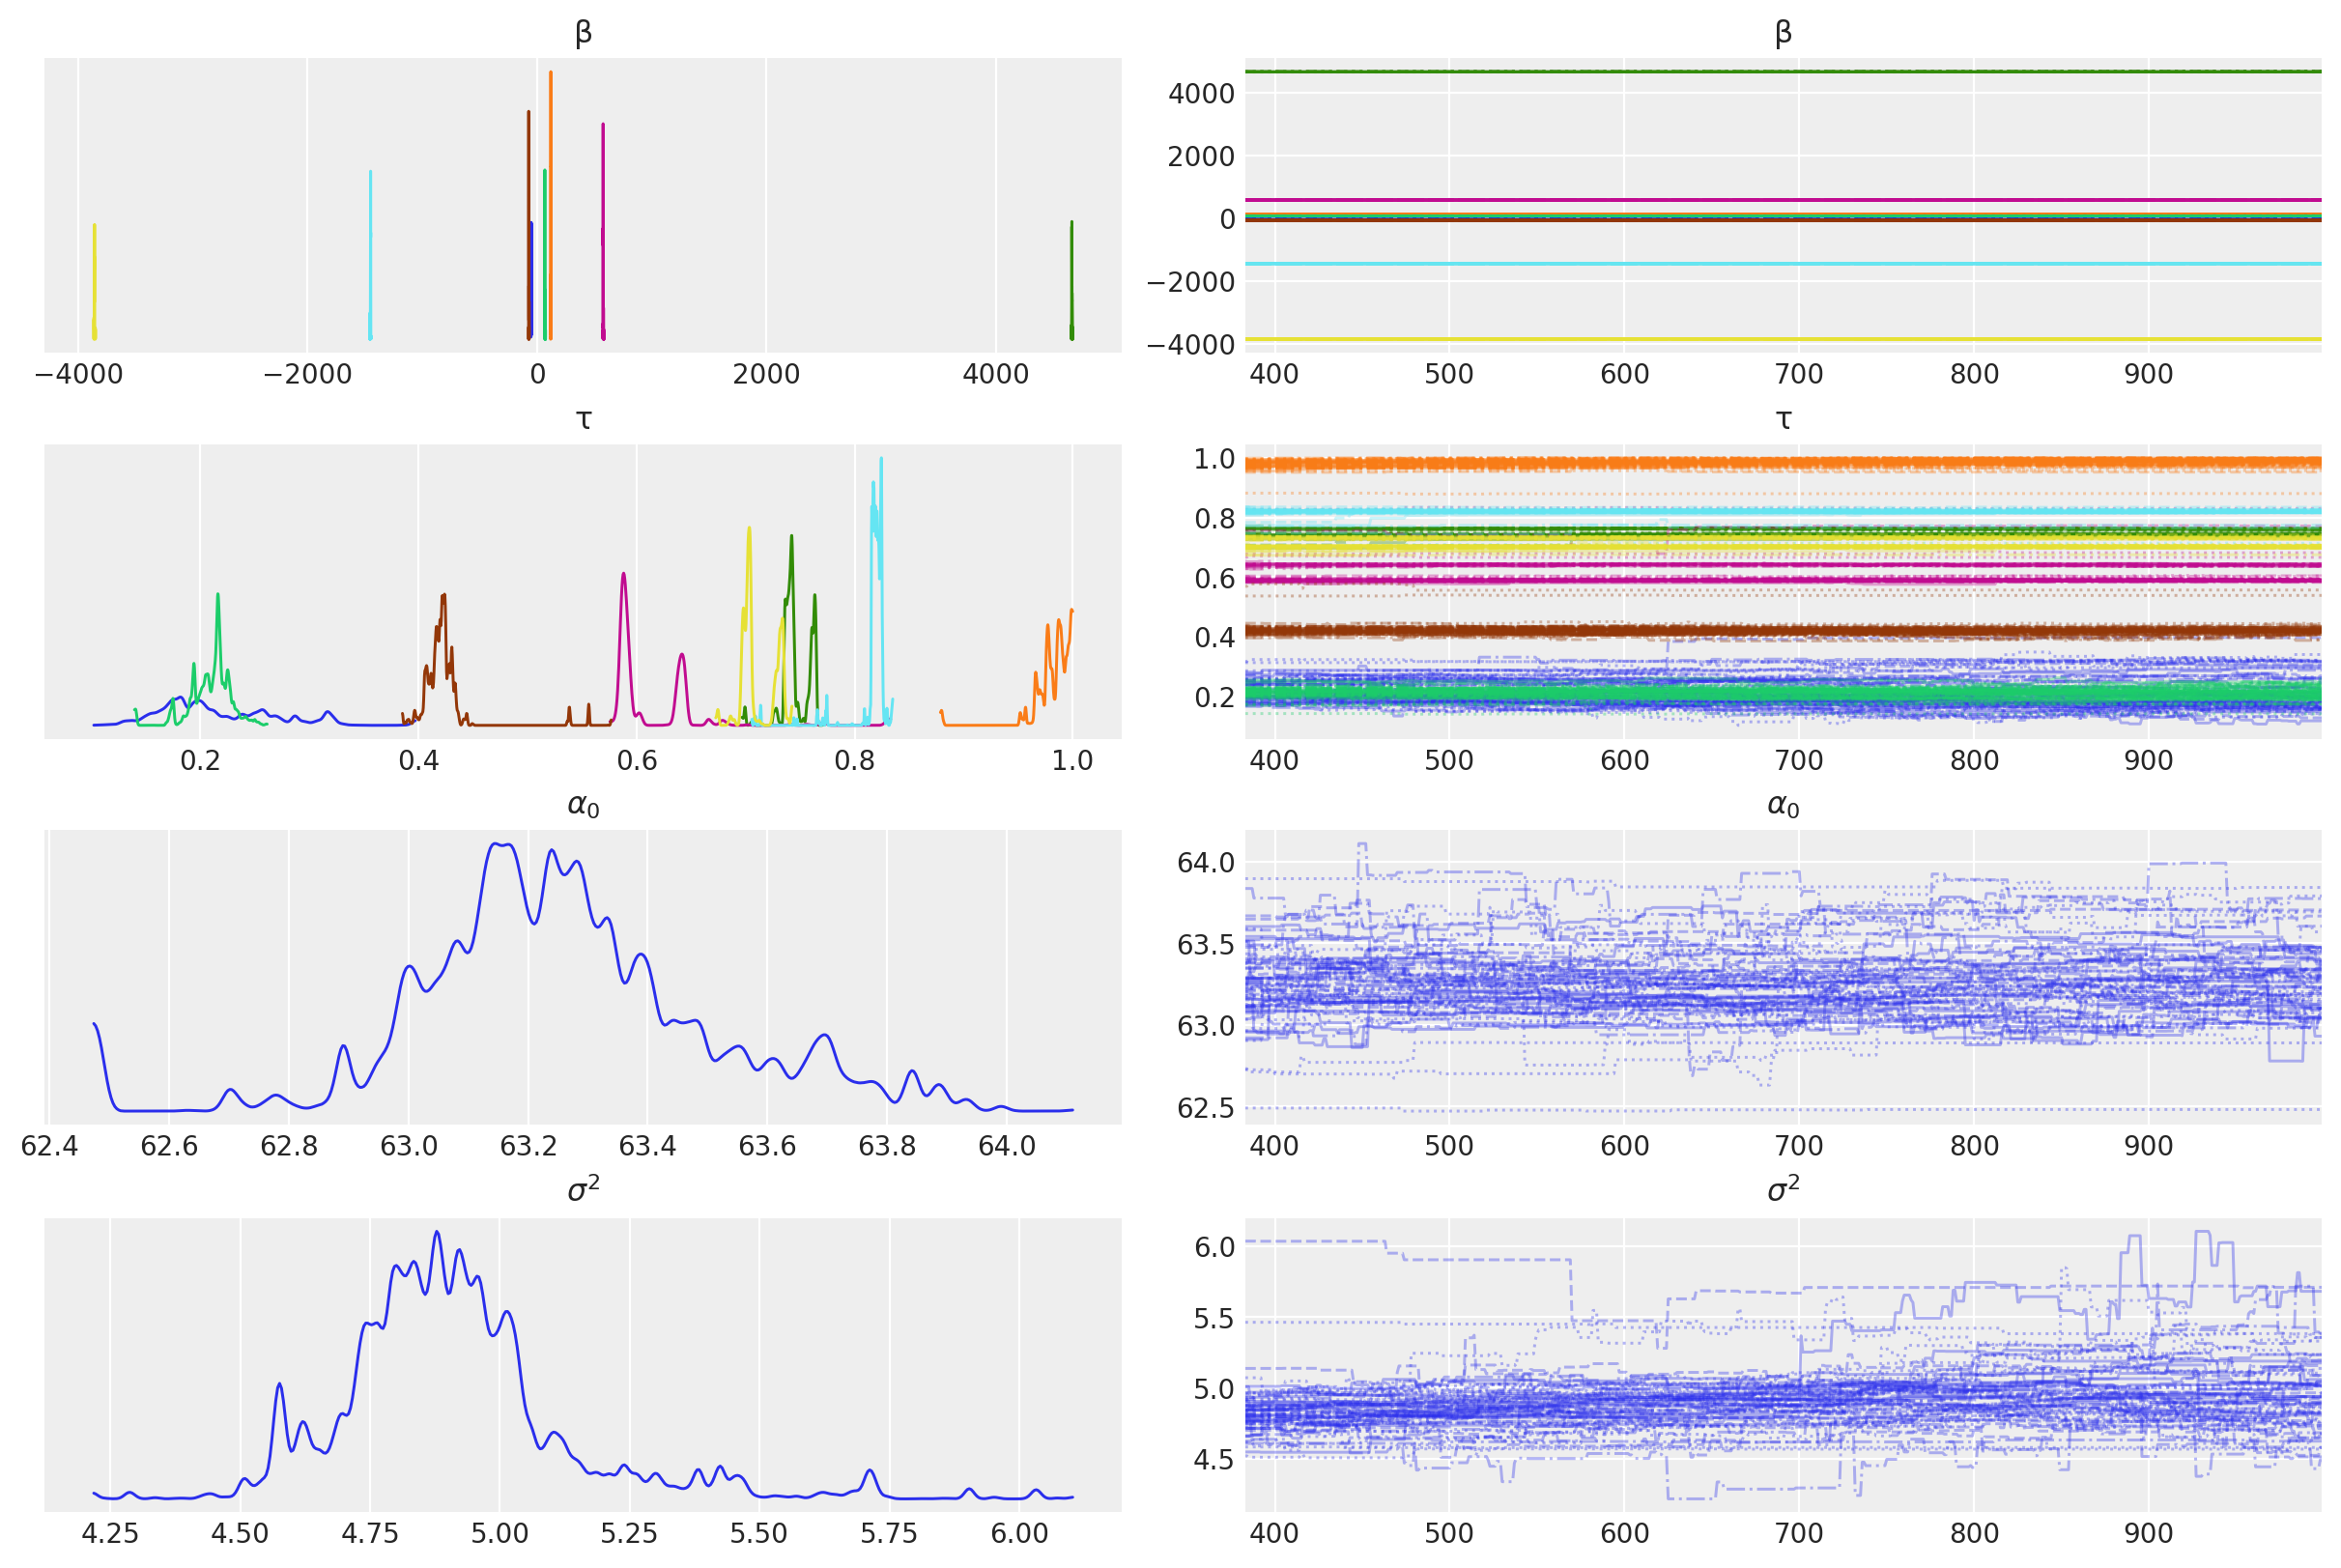

In [20]:
az.plot_trace(idata_emcee, labeller=theta_labeller,
              combined=True, var_names=theta_names)
print("Combined density and trace plot:")

Marginal posterior distributions:


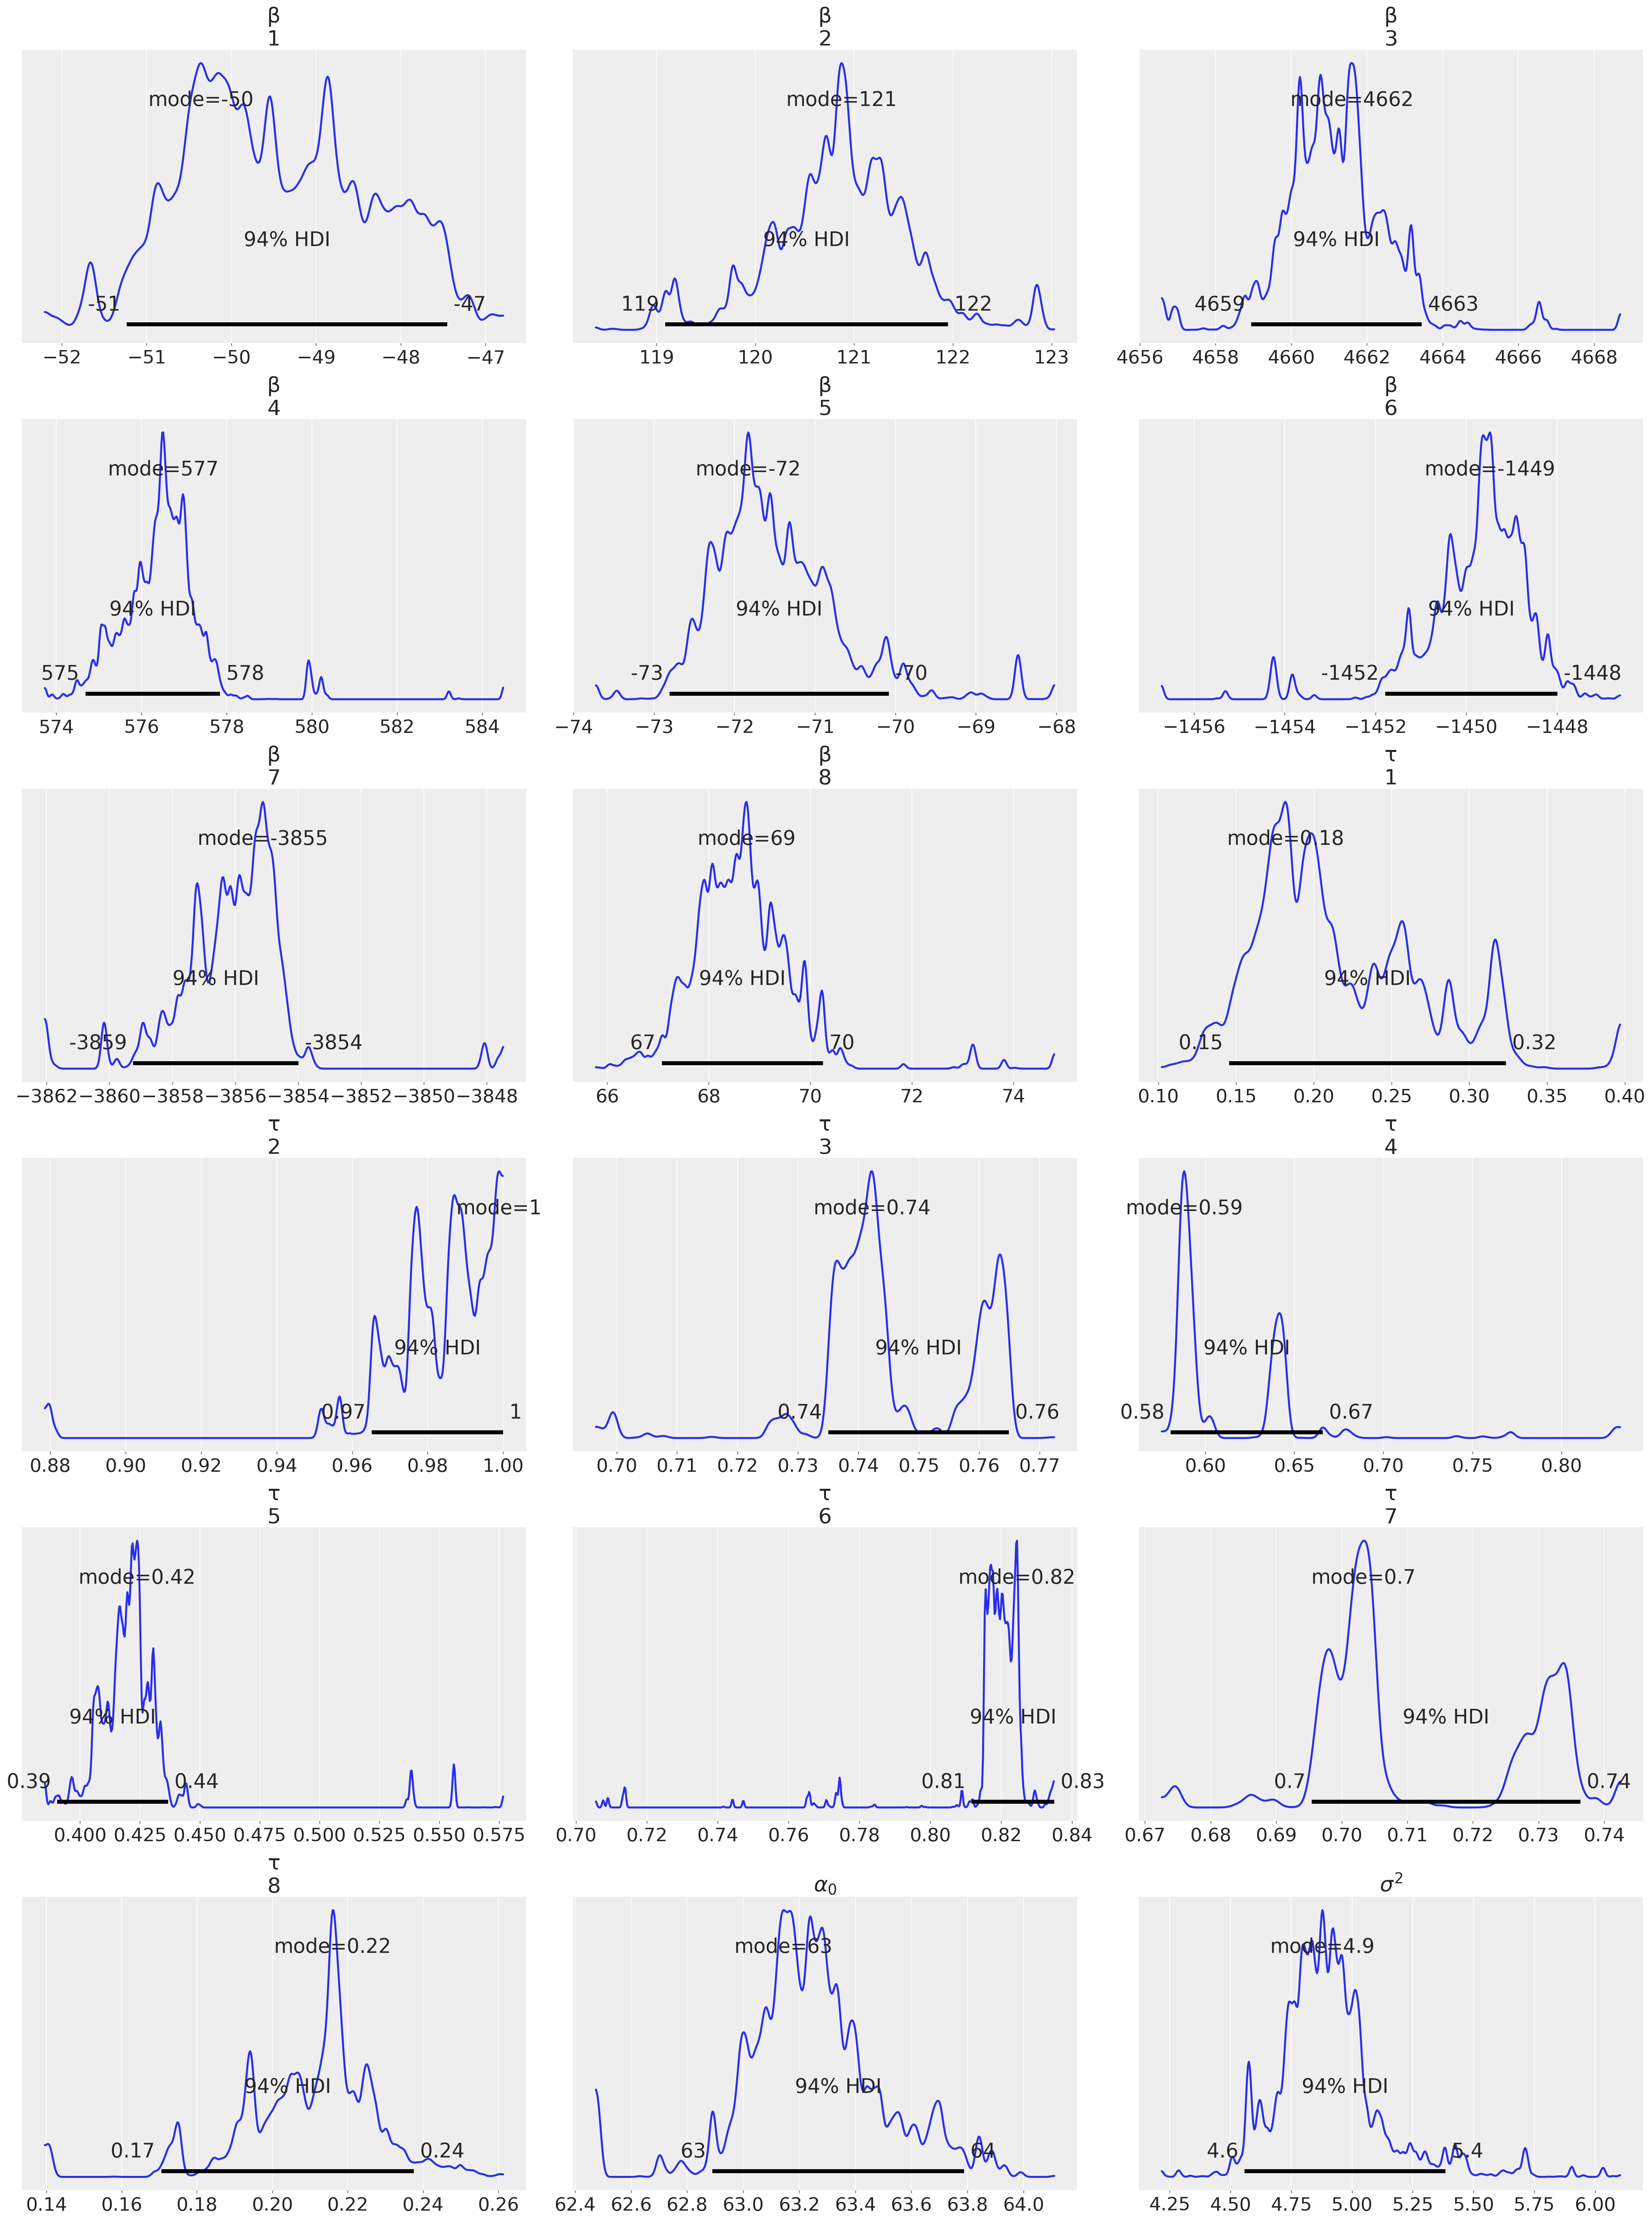

In [21]:
az.plot_posterior(idata_emcee, labeller=theta_labeller, point_estimate='mode',
                  grid=(NROWS(theta_ndim), NCOLS), textsize=20,
                  var_names=theta_names)
print("Marginal posterior distributions:")

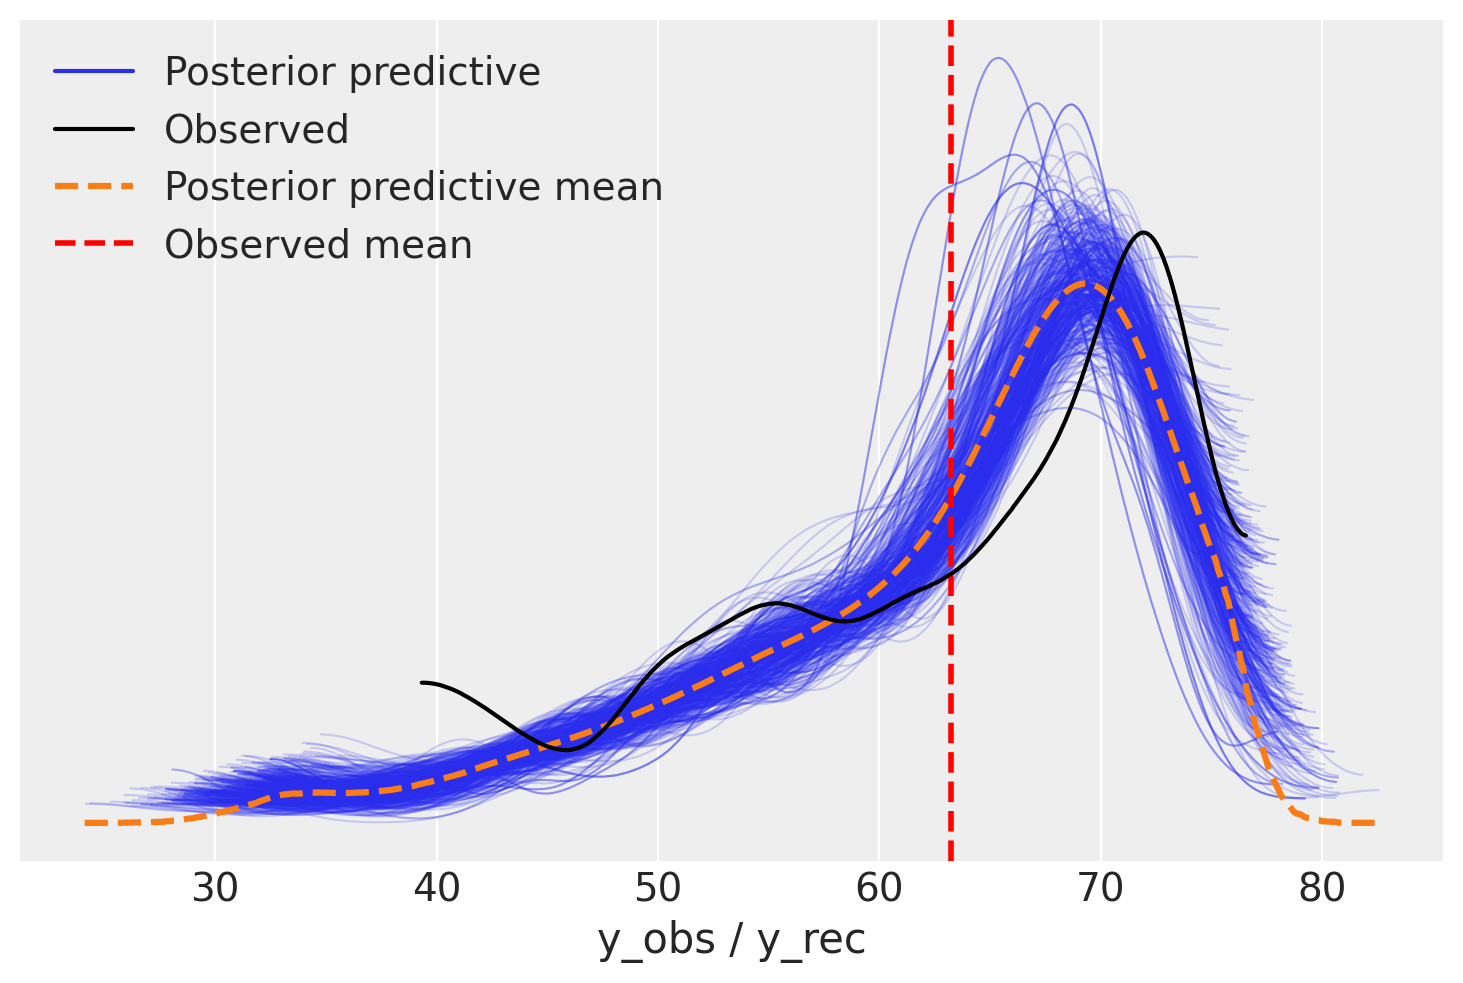

In [22]:
# -- Generate and plot posterior predictive samples from X

if "posterior_predictive" not in idata_emcee:
    ppc = utils.generate_ppc(idata_emcee, X, theta_names, rng=rng)
    idata_ppc = utils.ppc_to_idata(ppc, idata_emcee, "y_rec")
else:
    idata_ppc = idata_emcee

utils.plot_ppc(idata_ppc, n_samples=500, data_pairs={'y_obs': 'y_rec'})

Combined autocorrelation times:


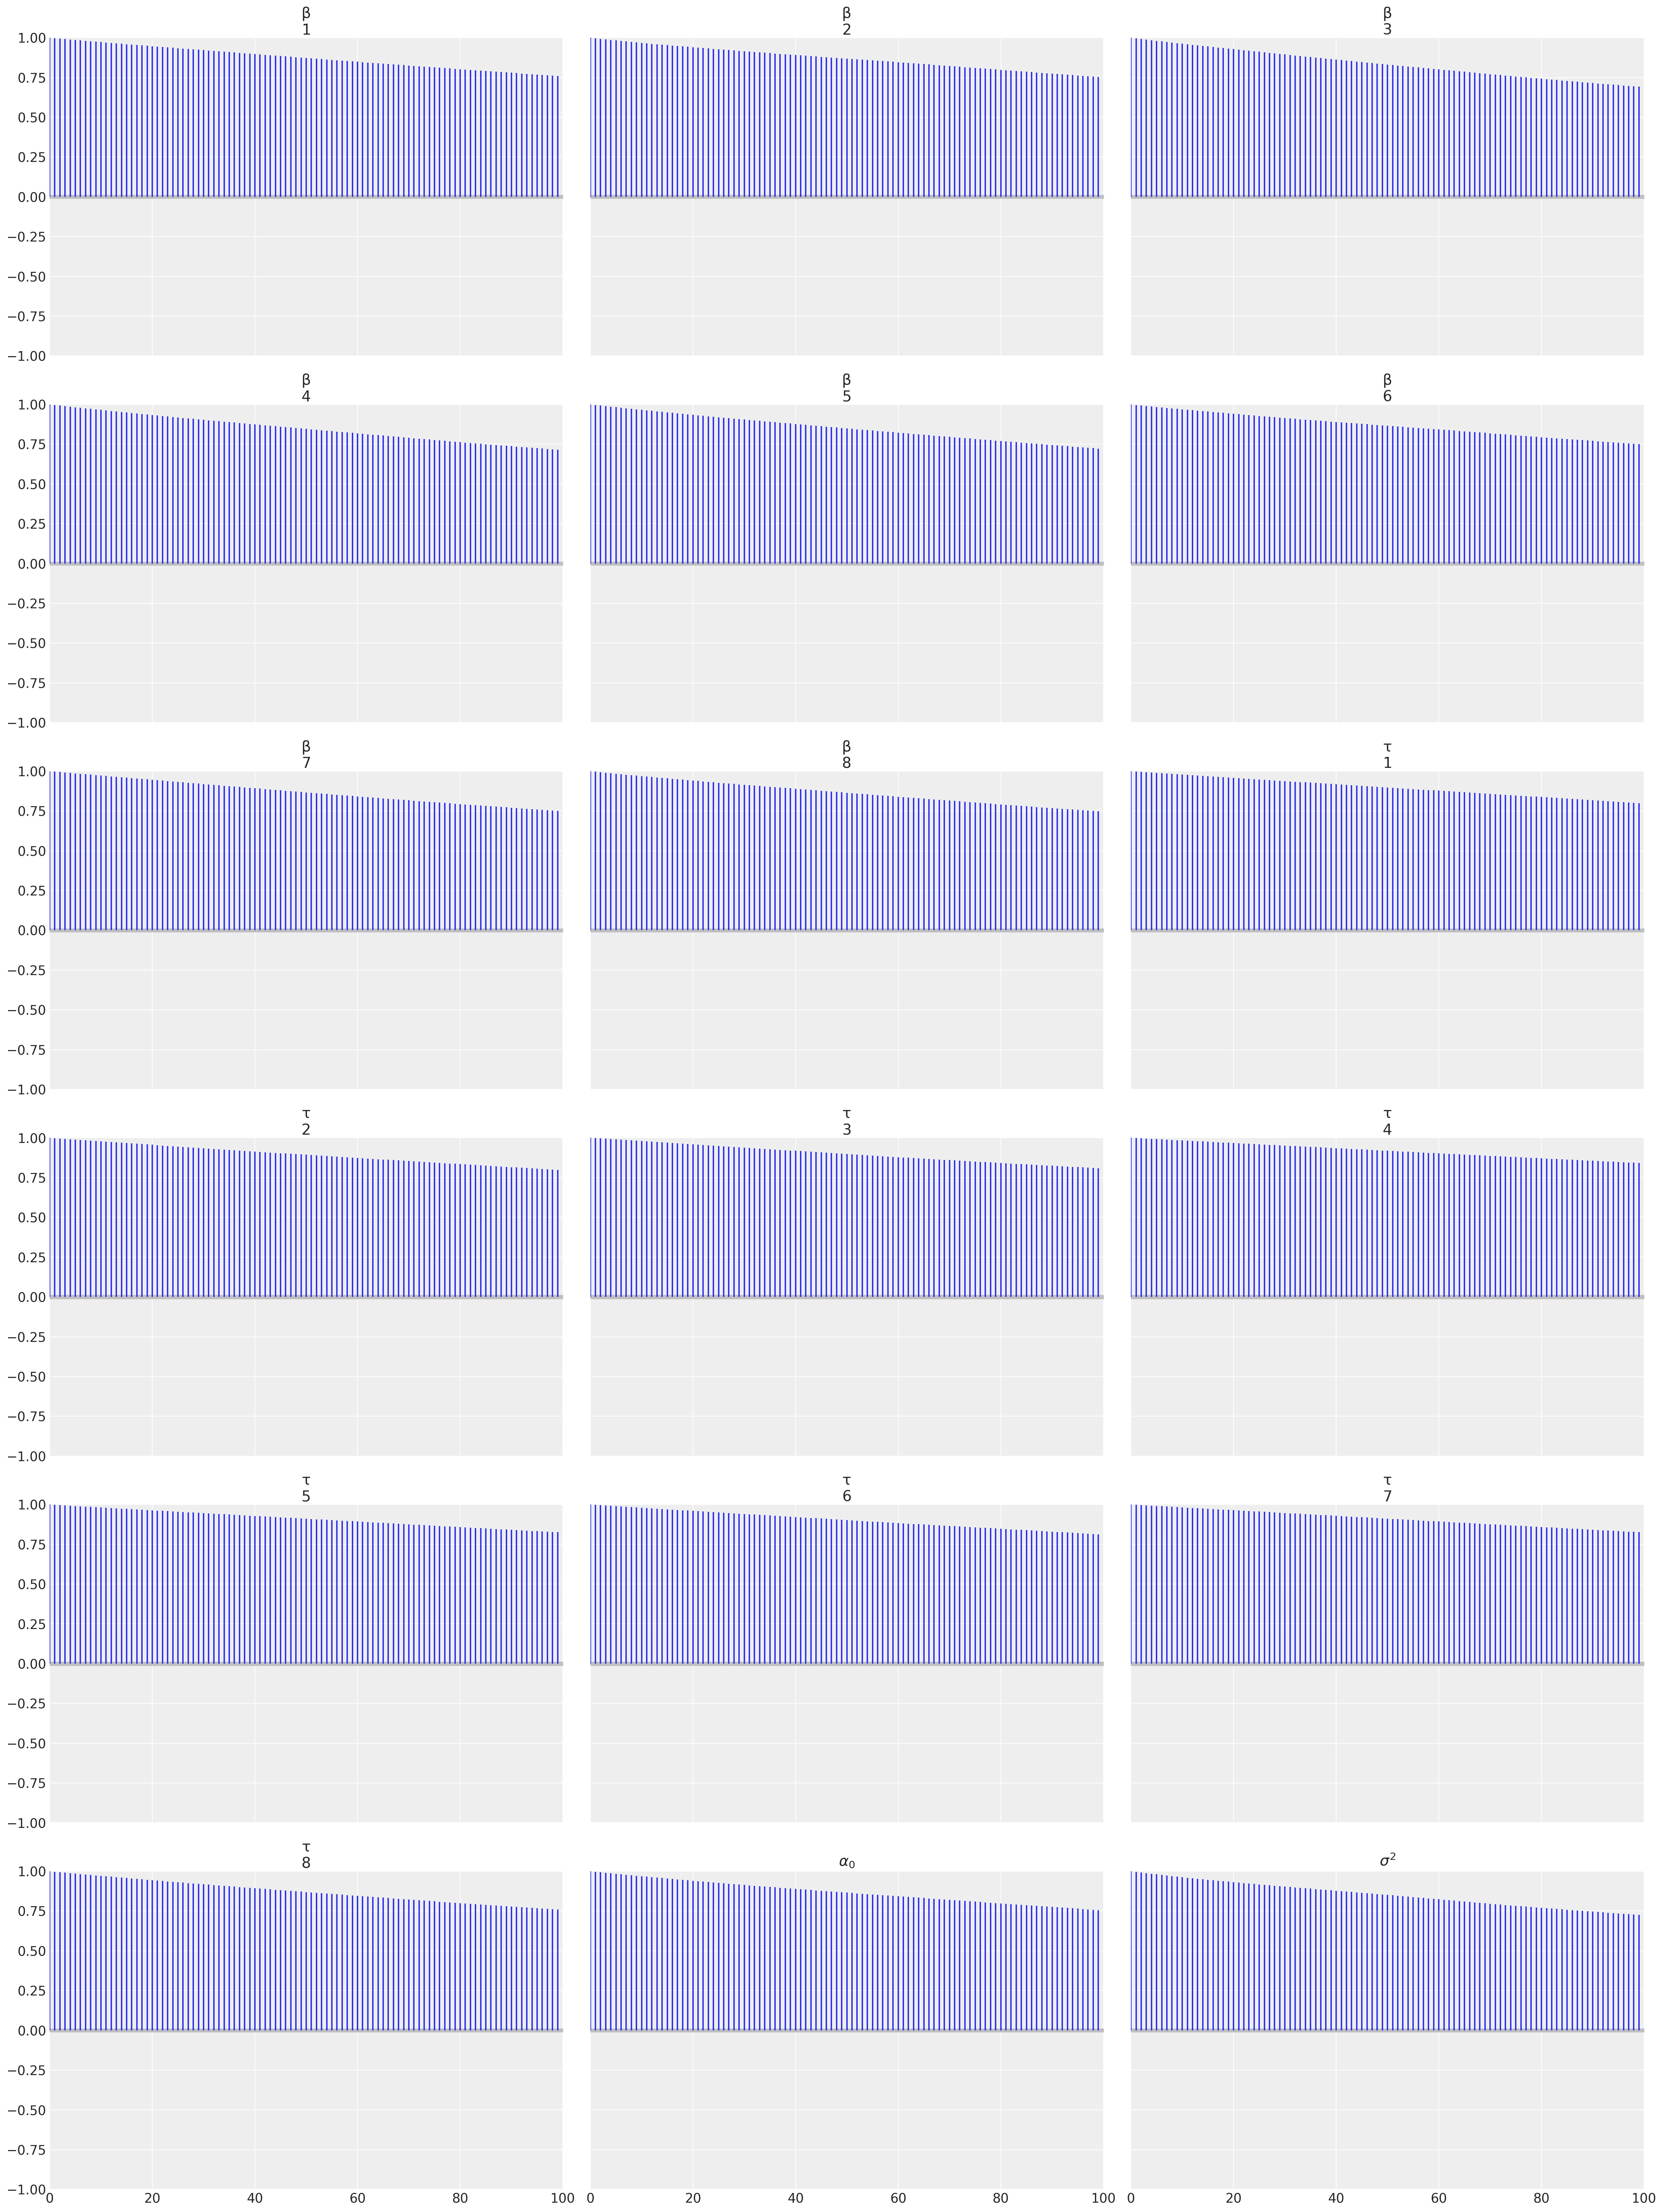

In [23]:
az.plot_autocorr(idata_emcee, combined=True, var_names=theta_names,
                 grid=(NROWS(theta_ndim), NCOLS), labeller=theta_labeller)
print("Combined autocorrelation times:")

### Out-of-sample predictions

Posterior predictive samples:   0%|          | 0/64 [00:00<?, ?it/s]

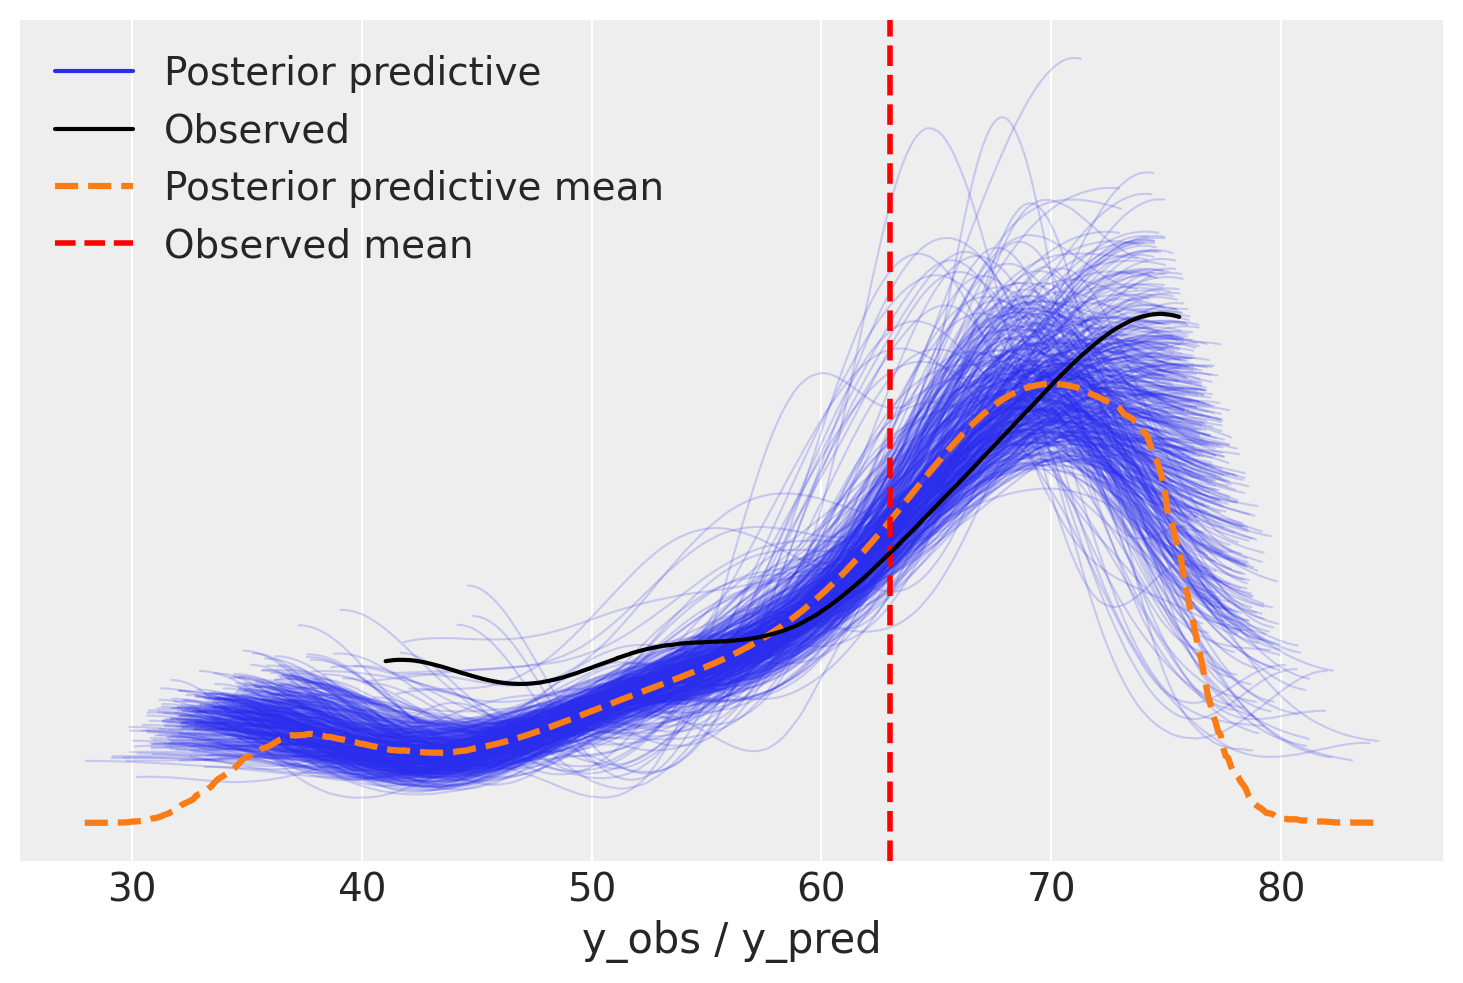

In [24]:
# -- Generate and plot posterior predictive samples from X_test

ppc = utils.generate_ppc(idata_emcee, X_test, theta_names, rng=rng)
idata_ppc = utils.ppc_to_idata(ppc, idata_emcee, "y_pred", y_obs=Y_test)

utils.plot_ppc(idata_ppc, n_samples=500, data_pairs={'y_obs': 'y_pred'})

In [25]:
# -- Compute metrics using several point estimates

point_estimates = ["mode", "mean", "median"]

df_metrics_emcee = pd.DataFrame(columns=results_columns)

for i, pe in enumerate(point_estimates):
    Y_hat = utils.point_predict(
        X_test, idata_emcee,
        theta_names, pe)
    metrics = utils.regression_metrics(Y_test, Y_hat)
    df_metrics_emcee.loc[i] = [
        "emcee_" + pe,
        p_hat,
        metrics["mse"],
        np.sqrt(metrics["mse"]),
        metrics["r2"]
    ]

df_metrics_emcee = df_metrics_emcee.append(df_metrics_sk)
df_metrics_emcee.sort_values(results_columns[-2], inplace=True)
df_metrics_emcee.style.hide_index()

### Save & Load

This is only for testing purposes; in a production environment one should use the [Backends](https://emcee.readthedocs.io/en/stable/user/backends/) feature of *emcee*.

In [ ]:
# -- Save

with open("emcee-p-fixed.idata", 'wb') as file:
    pickle.dump(idata_emcee, file)

In [ ]:
# -- Load

with open("emcee-p-fixed.idata", 'rb') as file:
    idata_emcee = pickle.load(file)
    trace = idata_emcee.posterior.to_array().to_numpy().T
    trace_flat = trace.reshape(-1, trace.shape[-1])  # All chains combined

## The PyMC library

In [26]:
import pymc3 as pm
import theano
import theano.tensor as tt

### Model

In [29]:
# -- Probabilistic model

def make_model(p, g, eta, X, Y, names, names_aux, mle_theta=None):
    n, N = X.shape
    grid = np.linspace(1./N, 1., N)

    if mle_theta is not None:
        b0 = mle_theta[:p]
    else:
        b0 = g*rng.standard_normal(size=p)  # <-- Change if needed

    with pm.Model() as model:
        X_pm = pm.Data('X', X)

        alpha0_and_log_sigma = pm.DensityDist(
            names_aux[0], lambda x: 0, shape=(2,))

        alpha0 = pm.Deterministic(names[-2], alpha0_and_log_sigma[0])

        log_sigma = alpha0_and_log_sigma[1]
        sigma = pm.math.exp(log_sigma)
        sigma2 = pm.Deterministic(names[-1], sigma**2)

        tau = pm.Uniform(names[1], 0.0, 1.0, shape=(p,))

        idx = np.abs(grid - tau[:, np.newaxis]).argmin(1)
        X_tau = X_pm[:, idx]
        G_tau = pm.math.matrix_dot(X_tau.T, X_tau)
        G_tau = (G_tau + G_tau.T)/2.  # Enforce symmetry
        G_tau_reg = G_tau + eta * \
            tt.max(tt.nlinalg.eigh(G_tau)[0])*np.identity(p)

        def beta_lprior(x):
            b = x - b0

            return (0.5*pm.math.logdet(G_tau_reg)
                    - p*log_sigma
                    - pm.math.matrix_dot(b.T, G_tau_reg, b)/(2.*g*sigma2))

        beta = pm.DensityDist(names[0], beta_lprior, shape=(p,))

        expected_obs = alpha0 + pm.math.matrix_dot(X_tau, beta)

        y_obs = pm.Normal('y_obs', mu=expected_obs, sigma=sigma, observed=Y)

    return model

### Experiments

In [44]:
# -- Hyperparameters

burn = 0
thin = 1

In [ ]:
# -- NUTS with auto initialization

model = make_model(p_hat, g, eta, X, Y, theta_names,
                   theta_names_aux[:1], mle_theta_tr)

with model:
    idata_pymc = pm.sample(1500, cores=N_CORES, tune=1000, 
                           target_accept=0.8,
                           return_inferencedata=True)

    idata_pymc = idata_pymc.sel(draw=slice(burn, None, thin))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, τ, α0 and log σ]


### Analysis

Since the tuning iterations already serve as burn-in, we keep the whole trace. In addition, we could consider thinning the samples.

Graphical model:


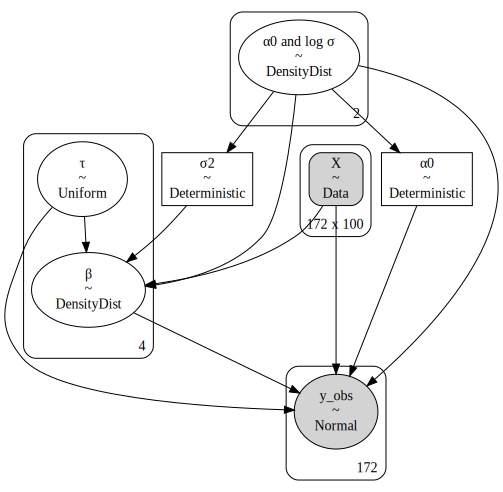

In [75]:
print("Graphical model:")
pm.model_graph.model_to_graphviz(model)

In [76]:
utils.summary(idata_pymc, var_names=theta_names, labeller=theta_labeller)

mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
β[0]         -7.176  1.077   -9.211   -5.204      0.076    0.054     199.0   
β[1]        190.022  1.163  187.995  192.215      0.071    0.051     265.0   
β[2]       -217.333  1.217 -219.683 -215.183      0.087    0.062     193.0   
β[3]         37.139  1.178   35.030   39.330      0.077    0.055     233.0   
τ[0]          0.887  0.155    0.657    1.000      0.009    0.006     328.0   
τ[1]          0.315  0.007    0.304    0.325      0.002    0.002      10.0   
τ[2]          0.385  0.008    0.373    0.395      0.003    0.002      10.0   
τ[3]          0.551  0.012    0.527    0.574      0.002    0.002      28.0   
$\alpha_0$   63.274  0.196   62.878   63.615      0.012    0.008     282.0   
$\sigma^2$    7.480  0.776    6.125    8.983      0.046    0.033     266.0   

            ess_tail  r_hat     mode   median  
β[0]           380.0   1.03   -7.586   -7.180  
β[1]           597.0   1.01  189.965  189.989  
β[2]           548.0   1.02 -217.024 -217.288  
β[3]           470.0   1.01   37.159   37.147  
τ[0]           322.0   1.02    0.999    0.933  
τ[1]            12.0   1.30    0.316    0.315  
τ[2]            12.0   1.34    0.393    0.386  
τ[3]            43.0   1.12    0.549    0.551  
$\alpha_0$     533.0   1.02   63.306   63.277  
$\sigma^2$     490.0   1.01    7.377    7.444

Density and trace plot:


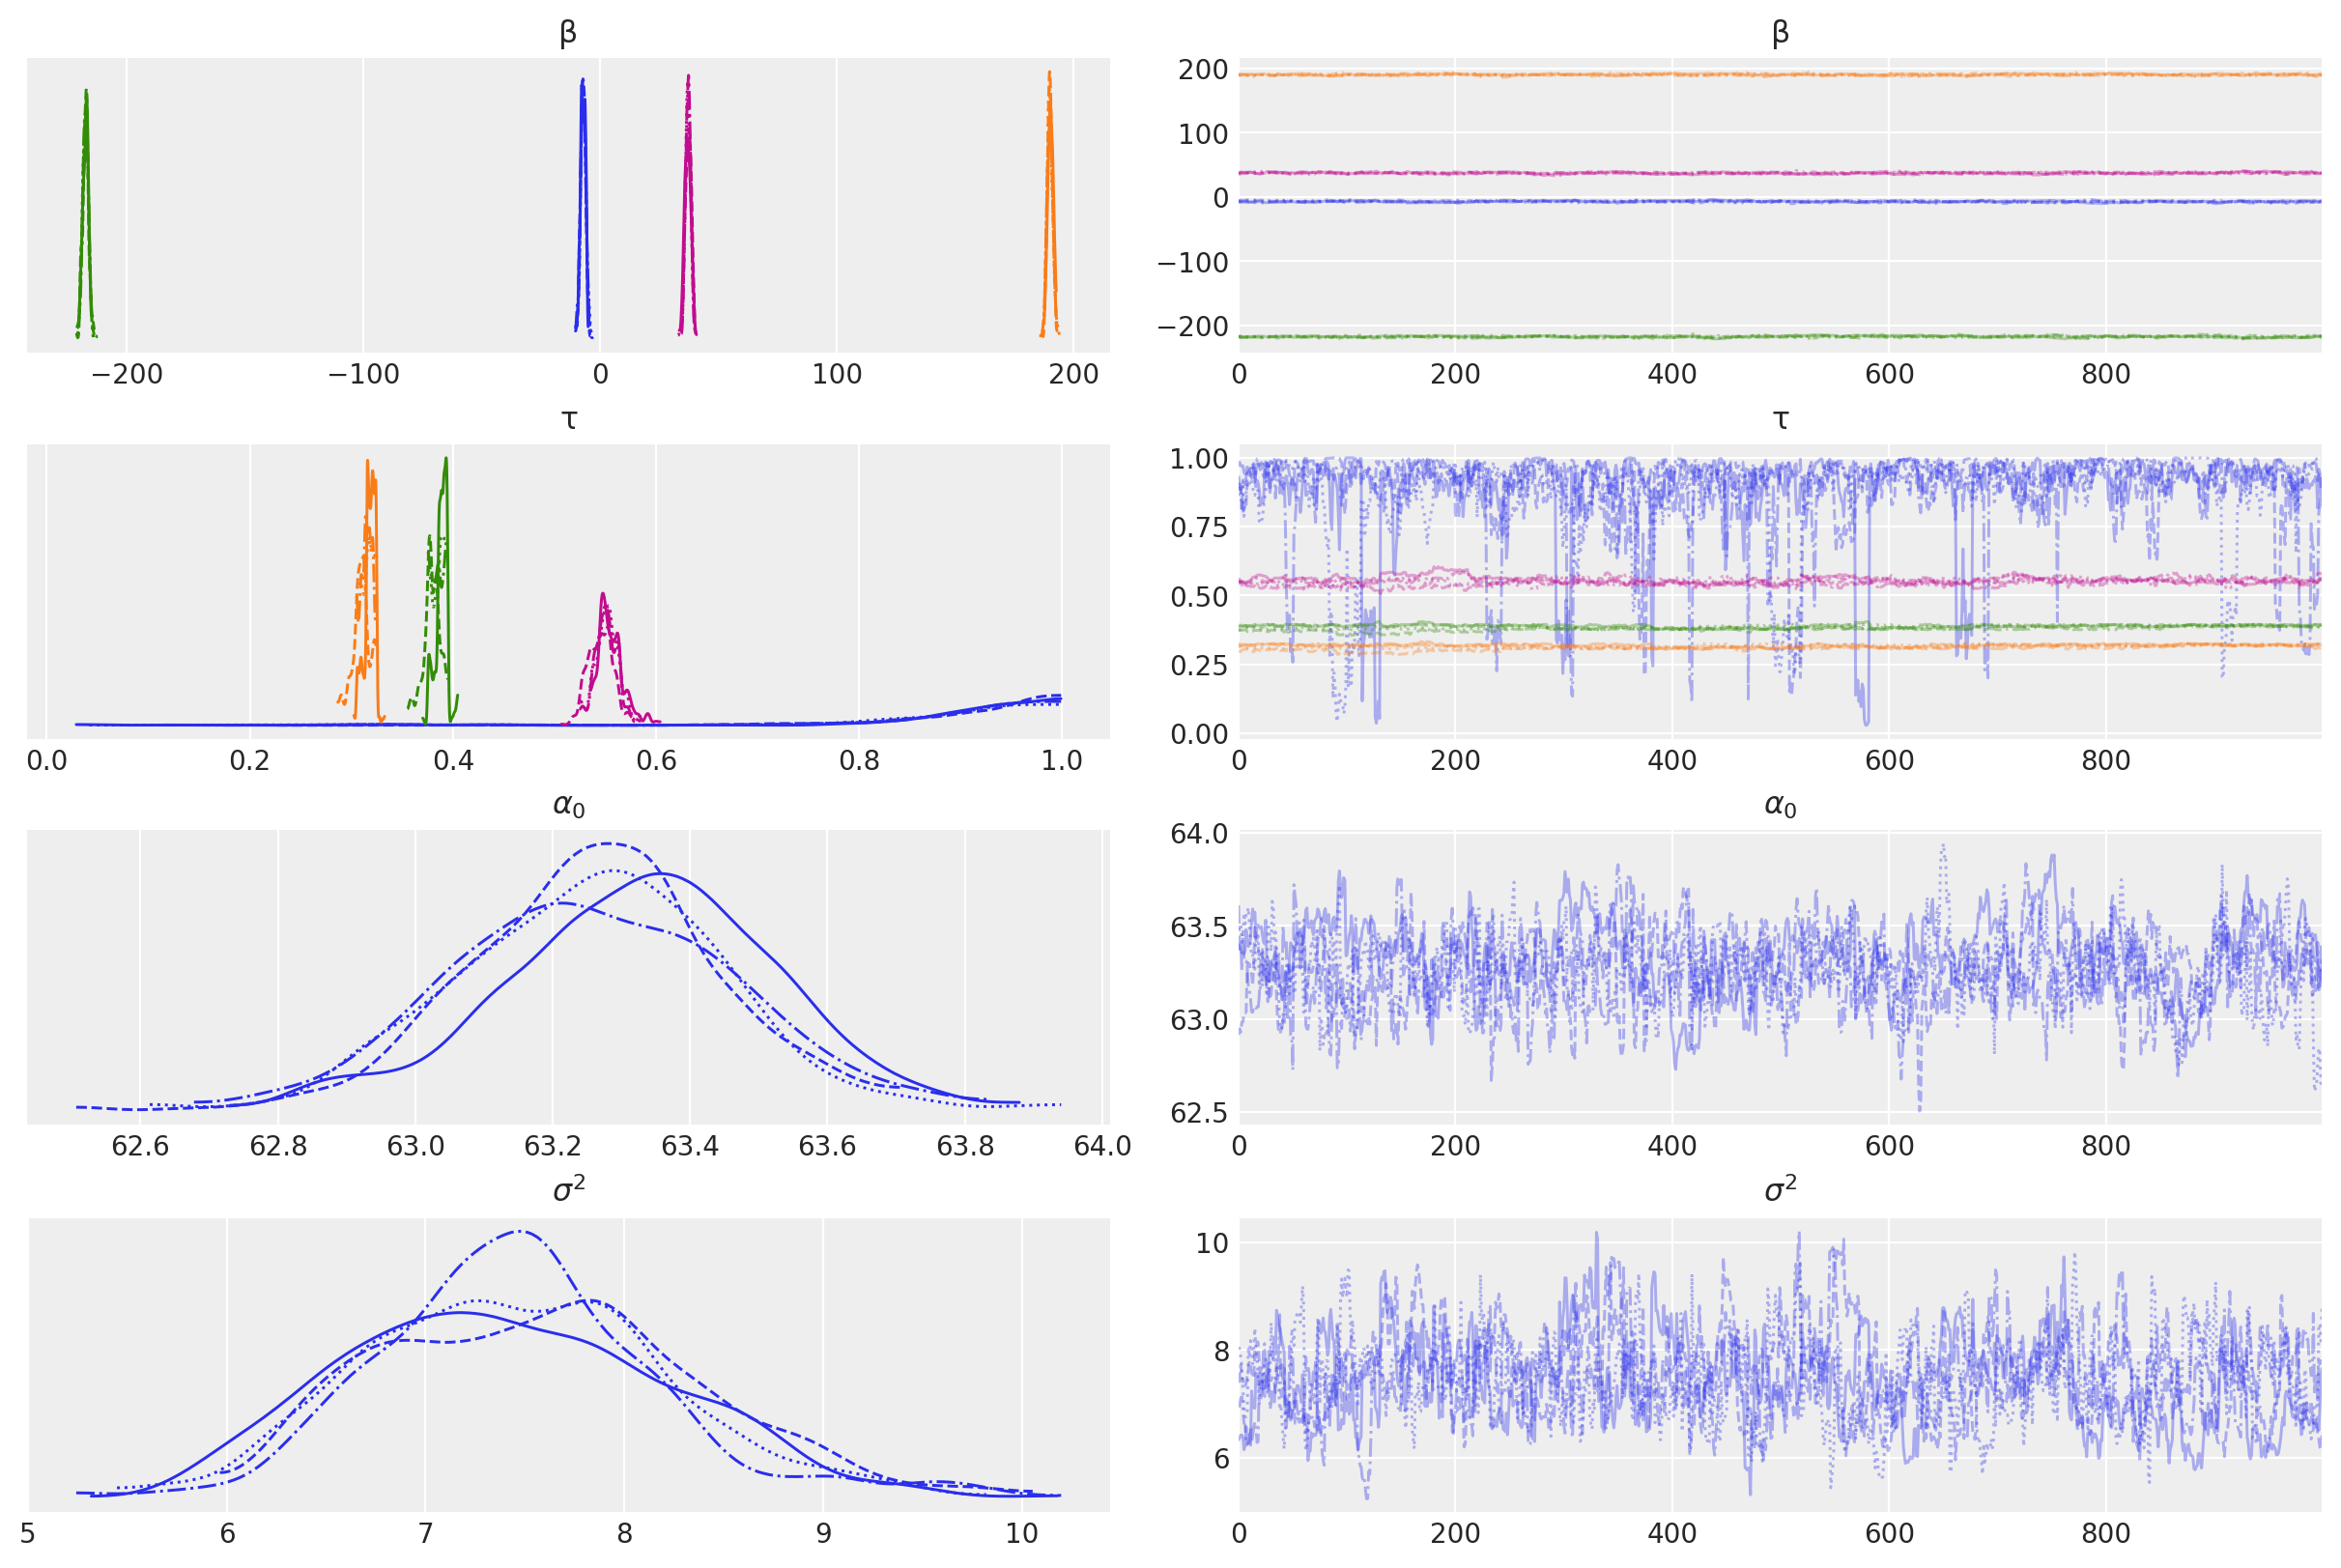

In [77]:
az.plot_trace(idata_pymc, var_names=theta_names, labeller=theta_labeller)
print("Density and trace plot:")

Marginal posterior distributions:


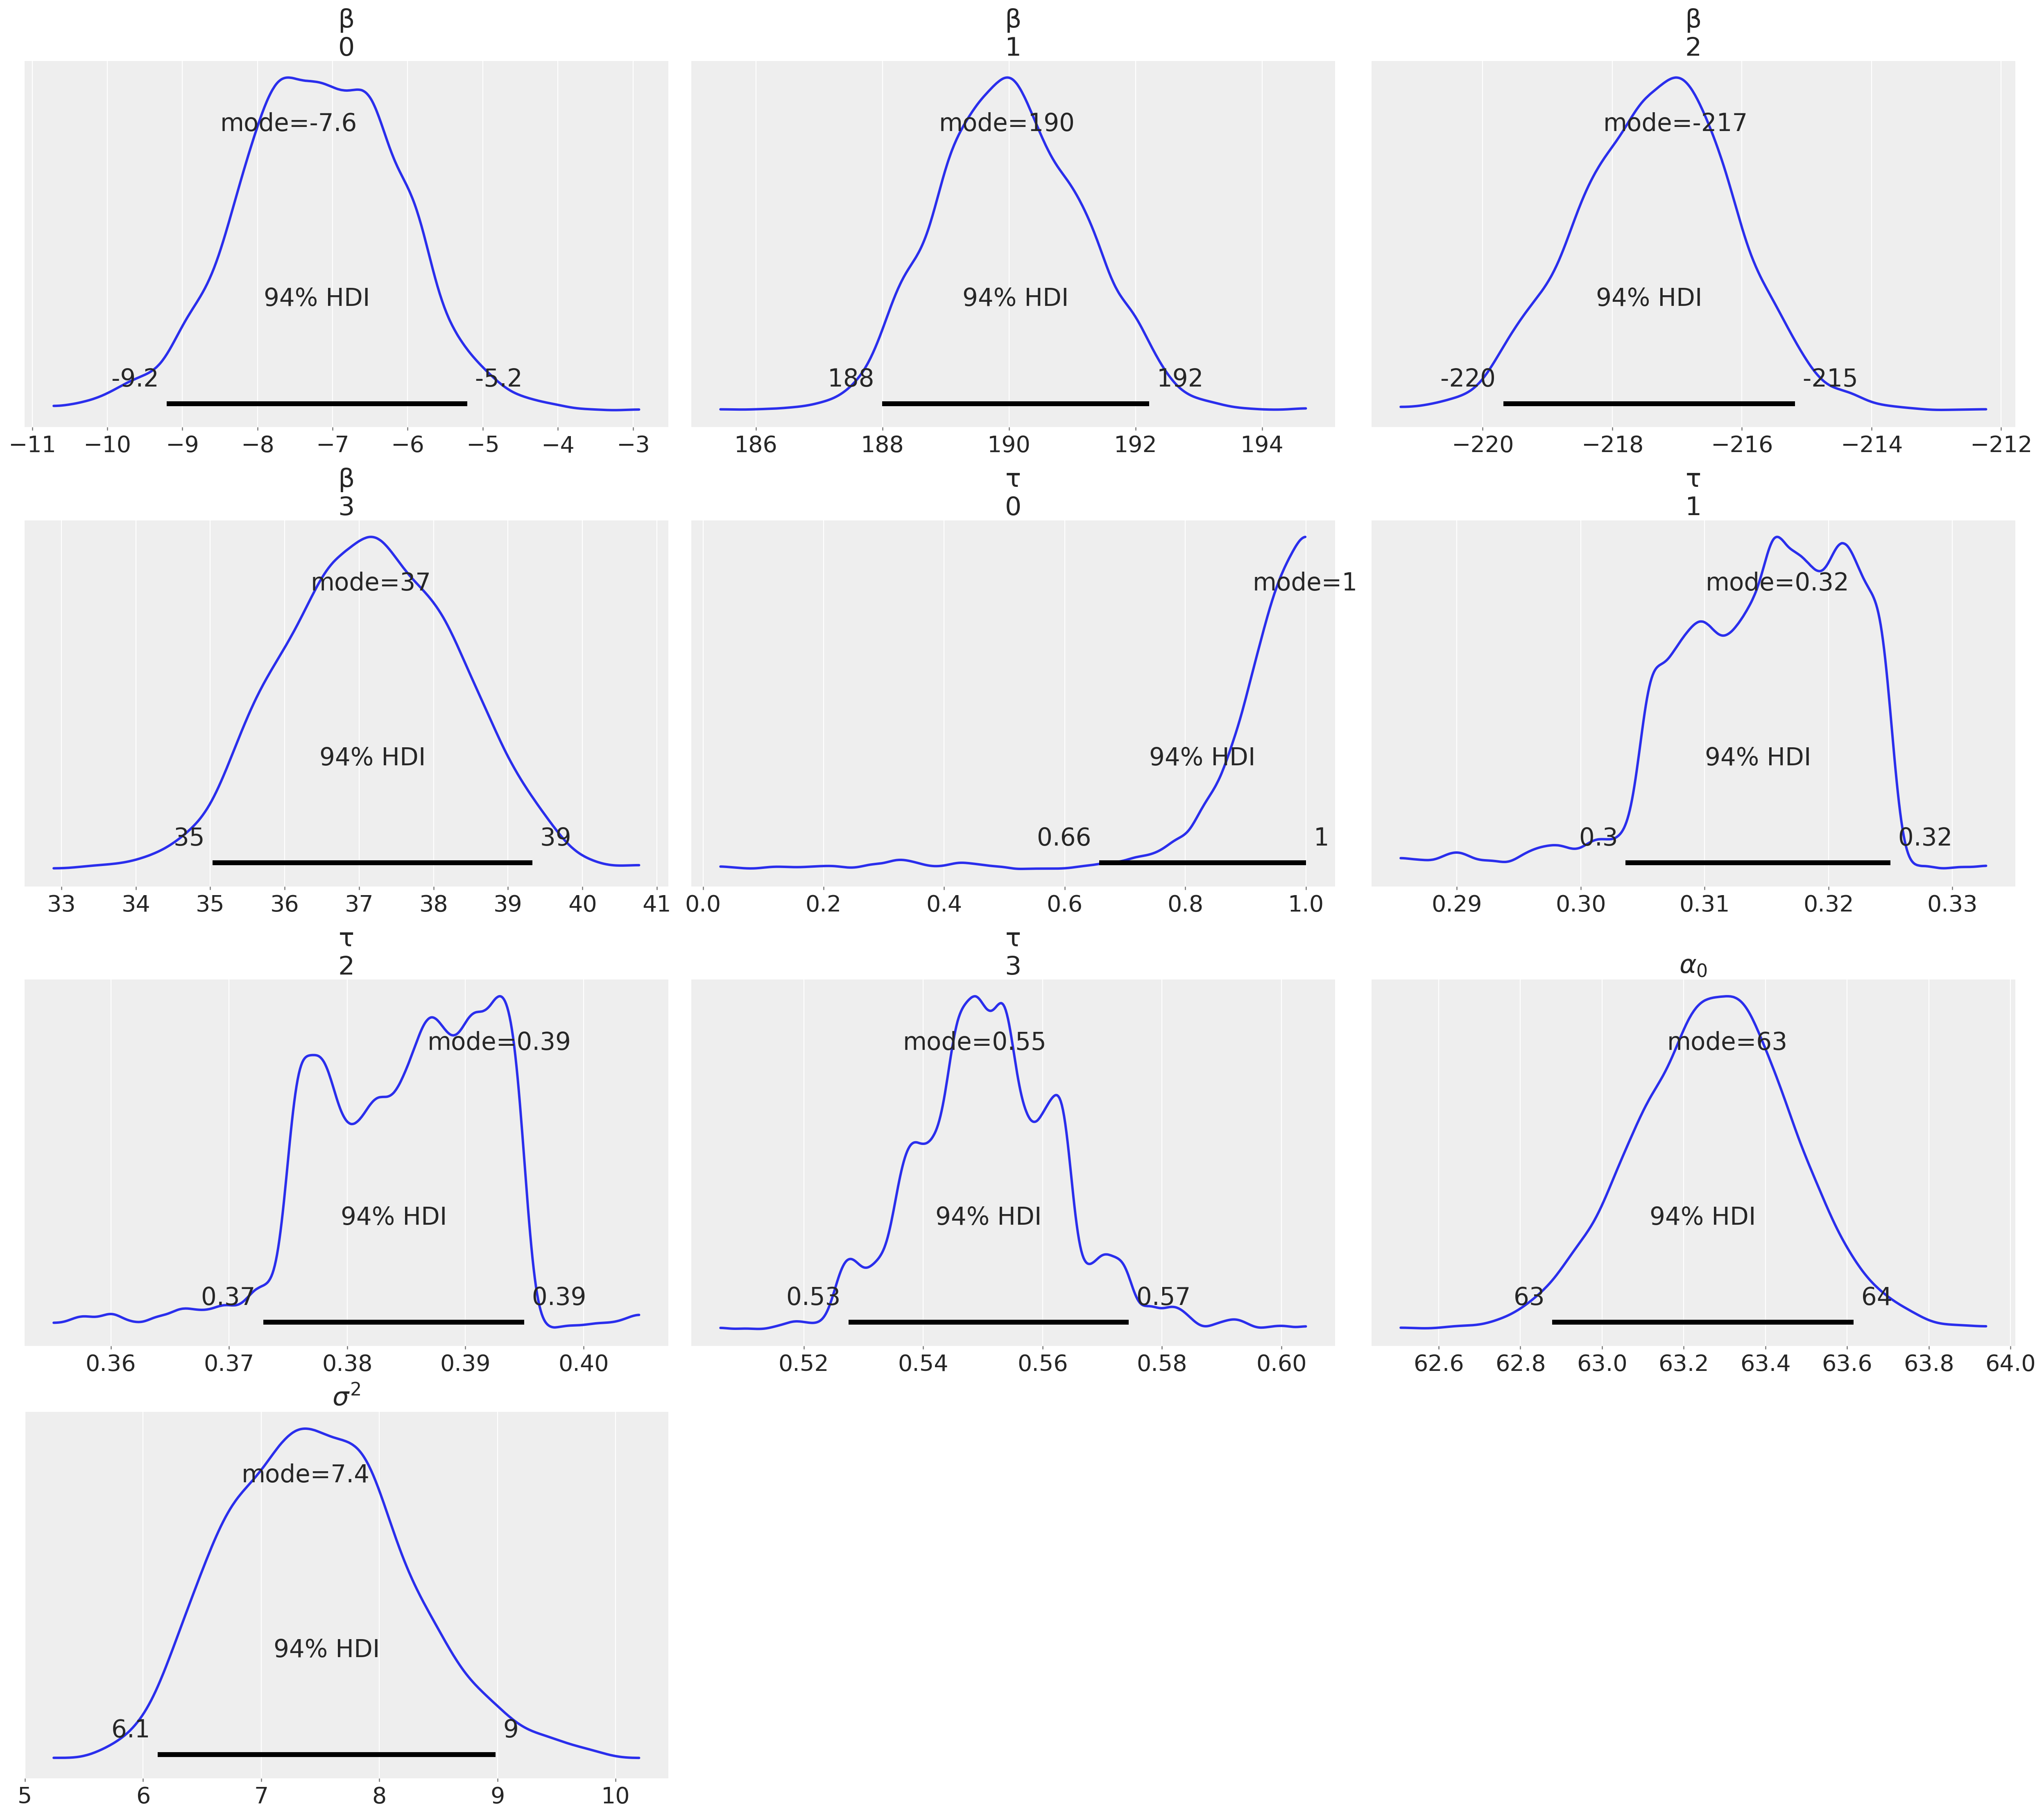

In [78]:
az.plot_posterior(
    idata_pymc, point_estimate='mode',
    var_names=theta_names,
    labeller=theta_labeller,
    textsize=20,
    grid=(NROWS(theta_ndim), NCOLS))
print("Marginal posterior distributions:")

Generating posterior predictive samples...


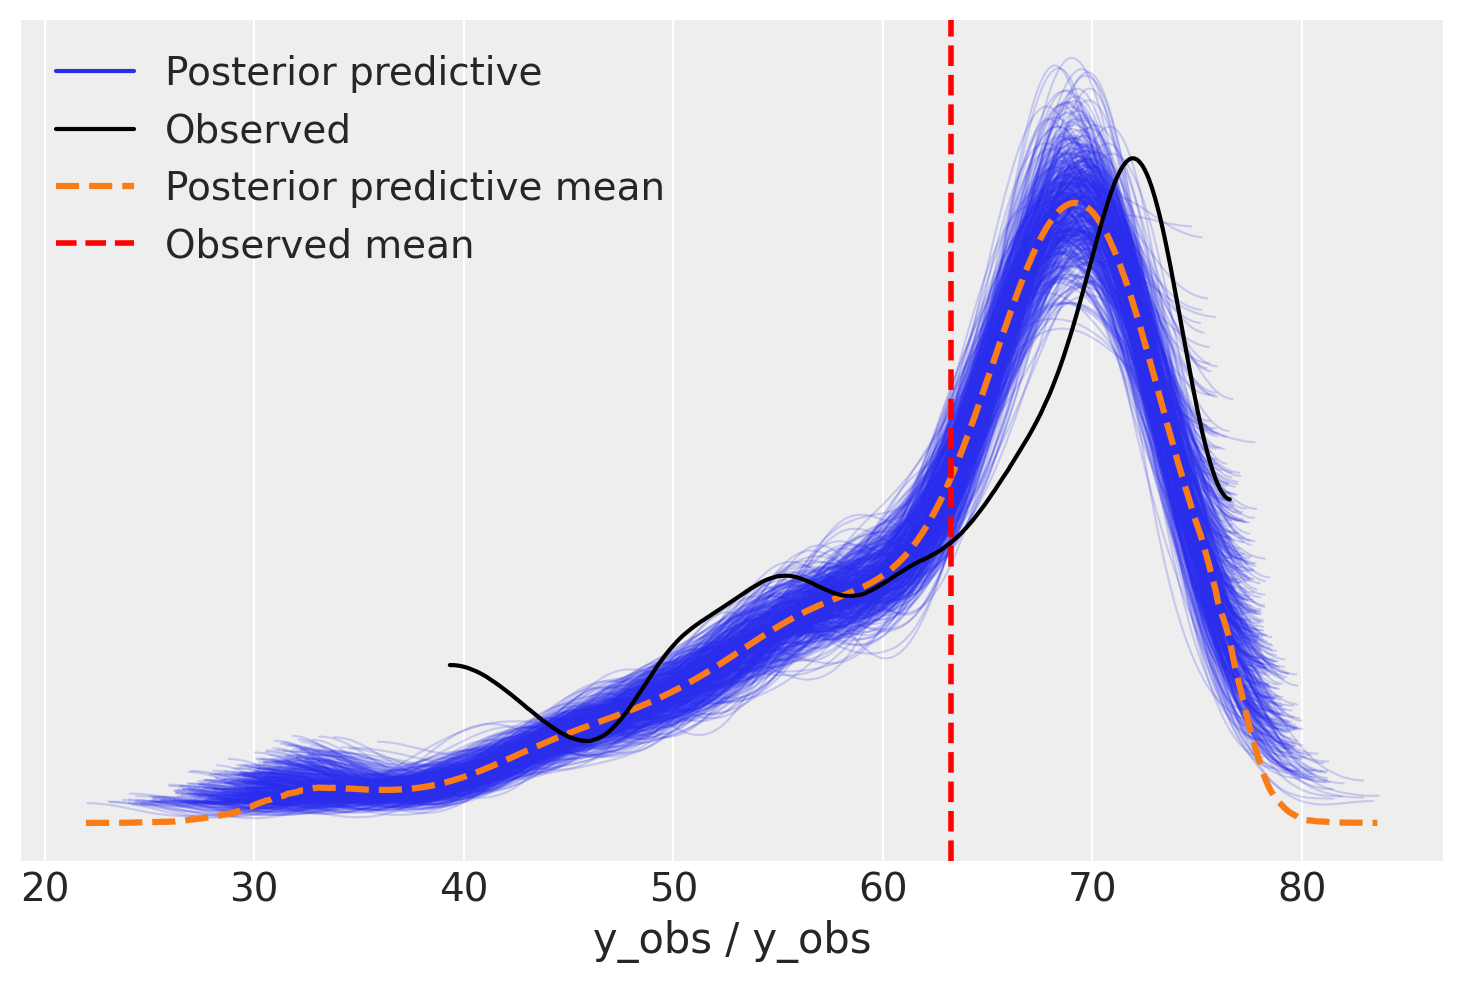

In [79]:
# -- Generate and plot posterior predictive samples from X

with model:
    print("Generating posterior predictive samples...")
    ppc = pm.sample_posterior_predictive(idata_pymc)
    idata_pymc.extend(az.from_pymc3(posterior_predictive=ppc))

utils.plot_ppc(idata_pymc, n_samples=500, data_pairs={'y_obs': 'y_obs'})

Combined autocorrelation times:


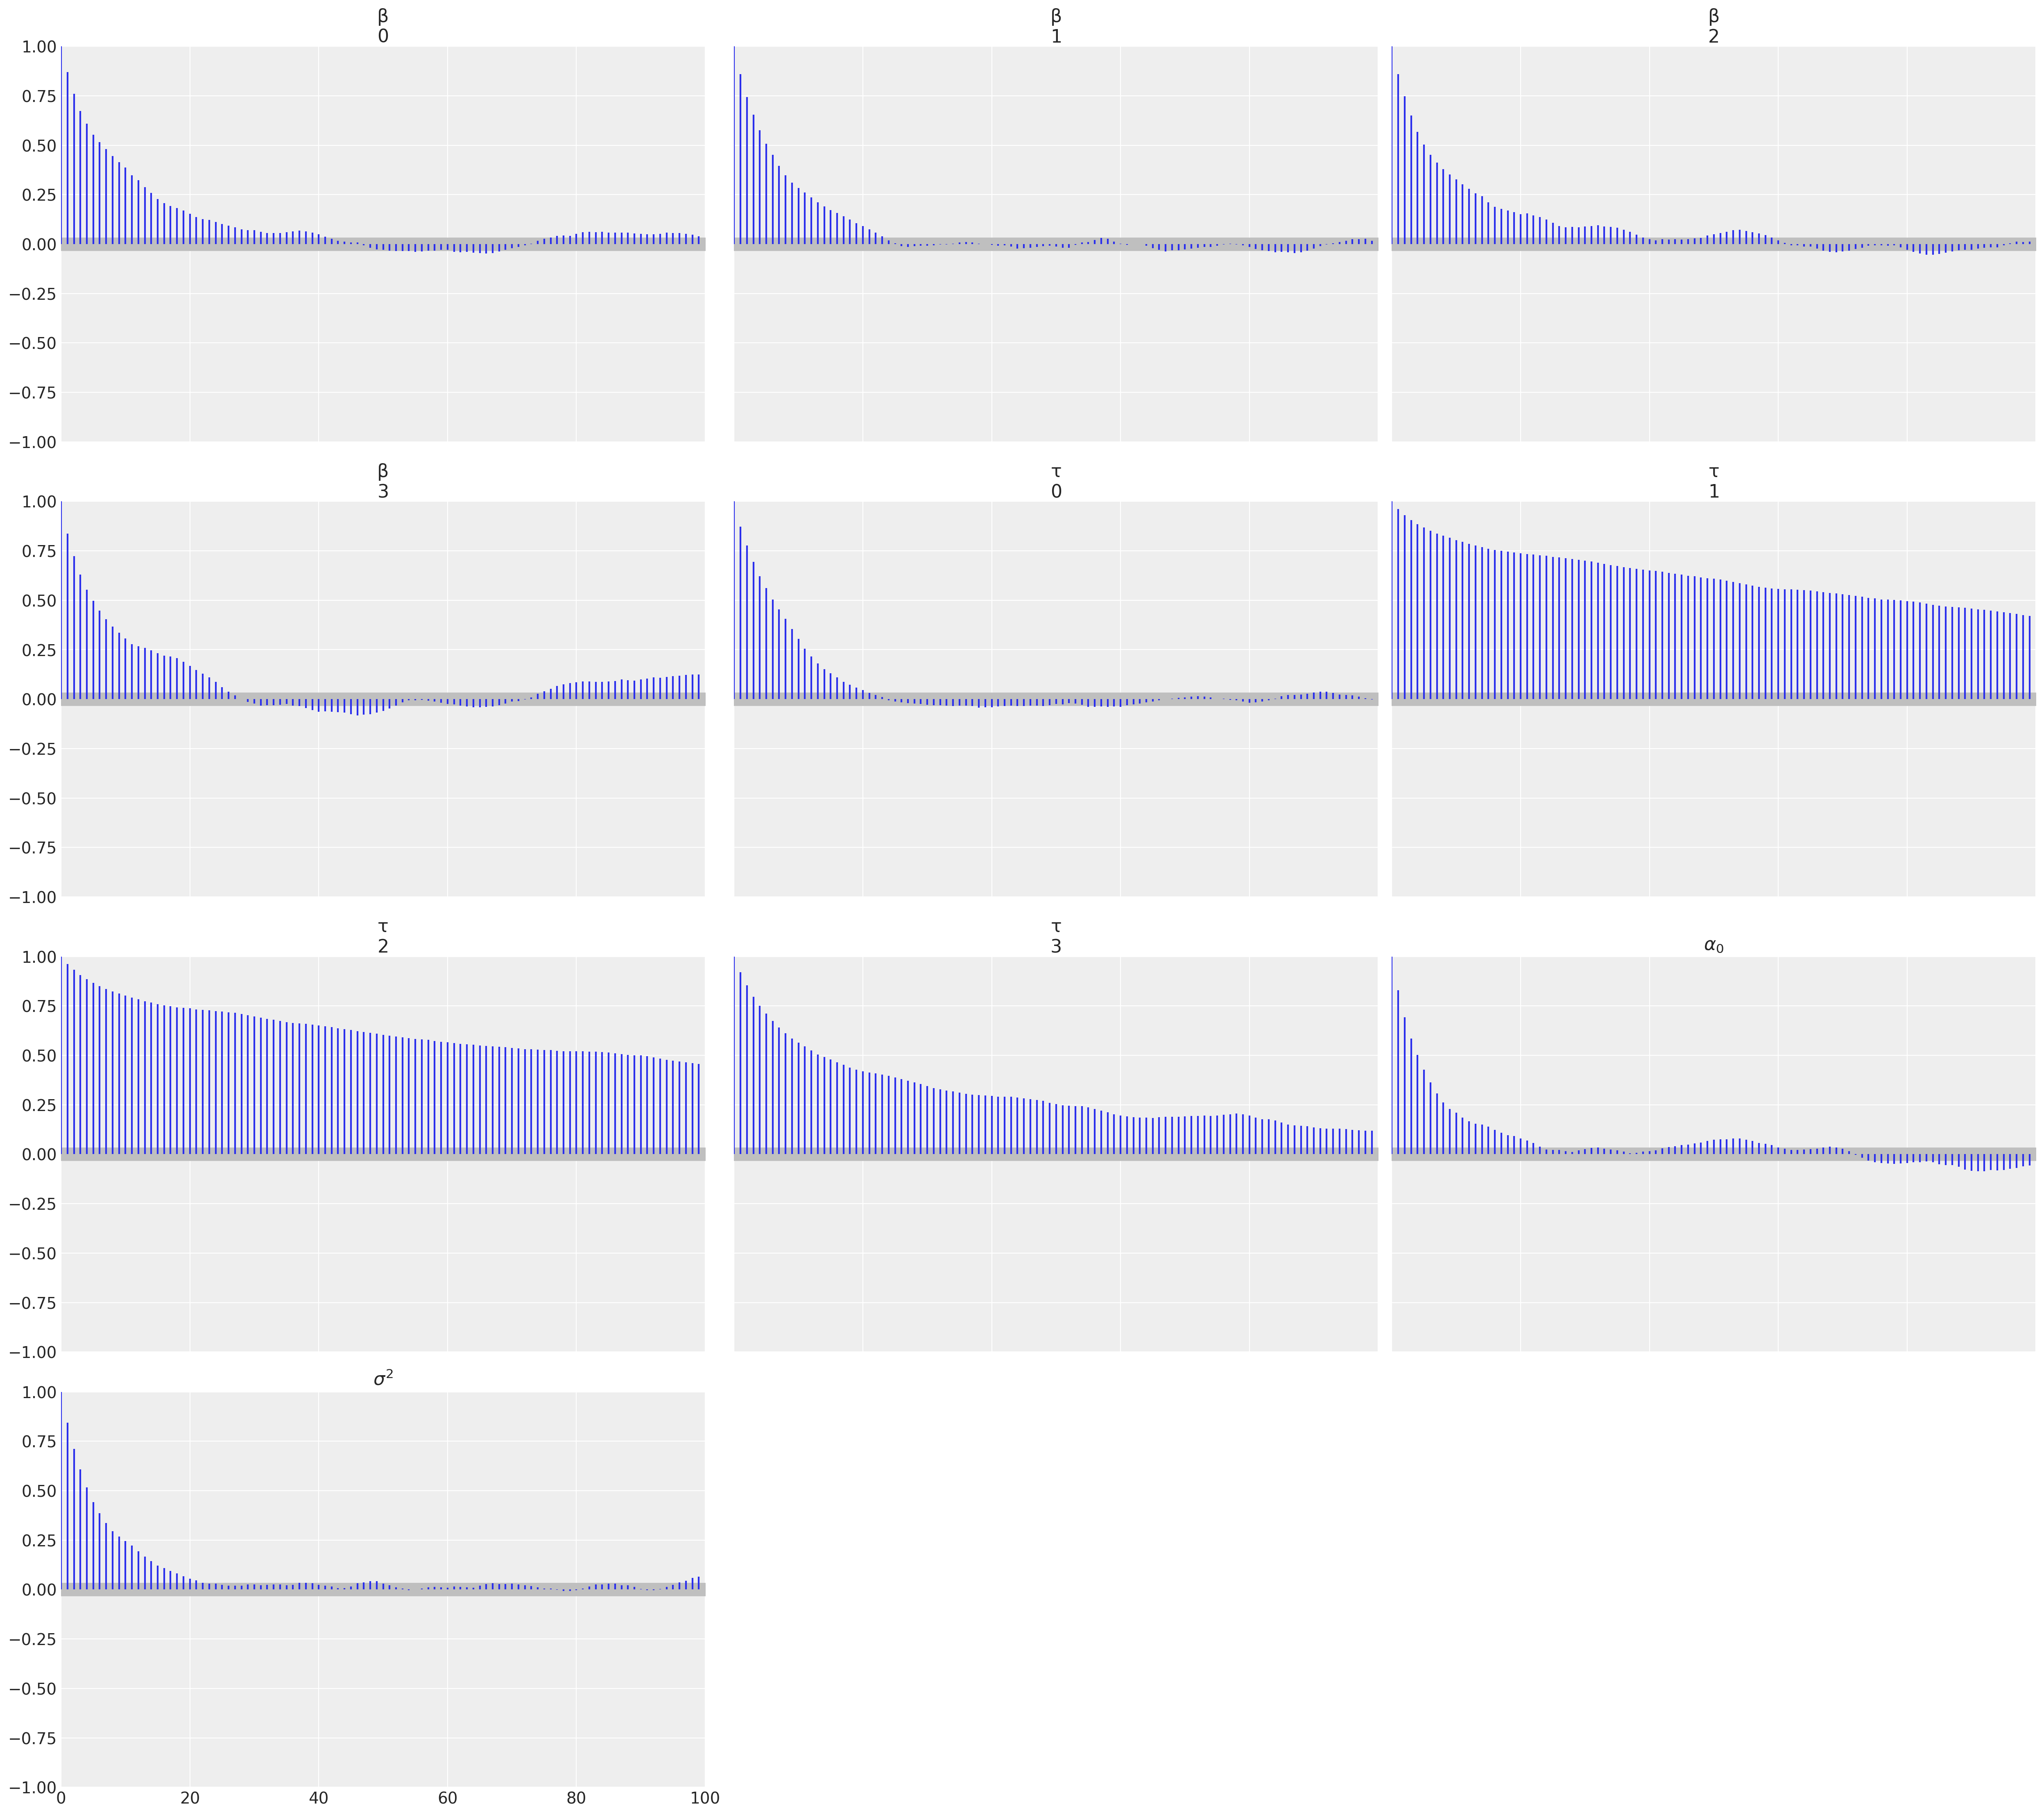

In [80]:
az.plot_autocorr(idata_pymc, var_names=theta_names,
                 combined=True, grid=(NROWS(theta_ndim), NCOLS),
                 labeller=theta_labeller)
print("Combined autocorrelation times:")

### Out-of-sample predictions

First we take a look at the distribution of predictions on a previously unseen dataset.

Generating posterior predictive on hold-out data...


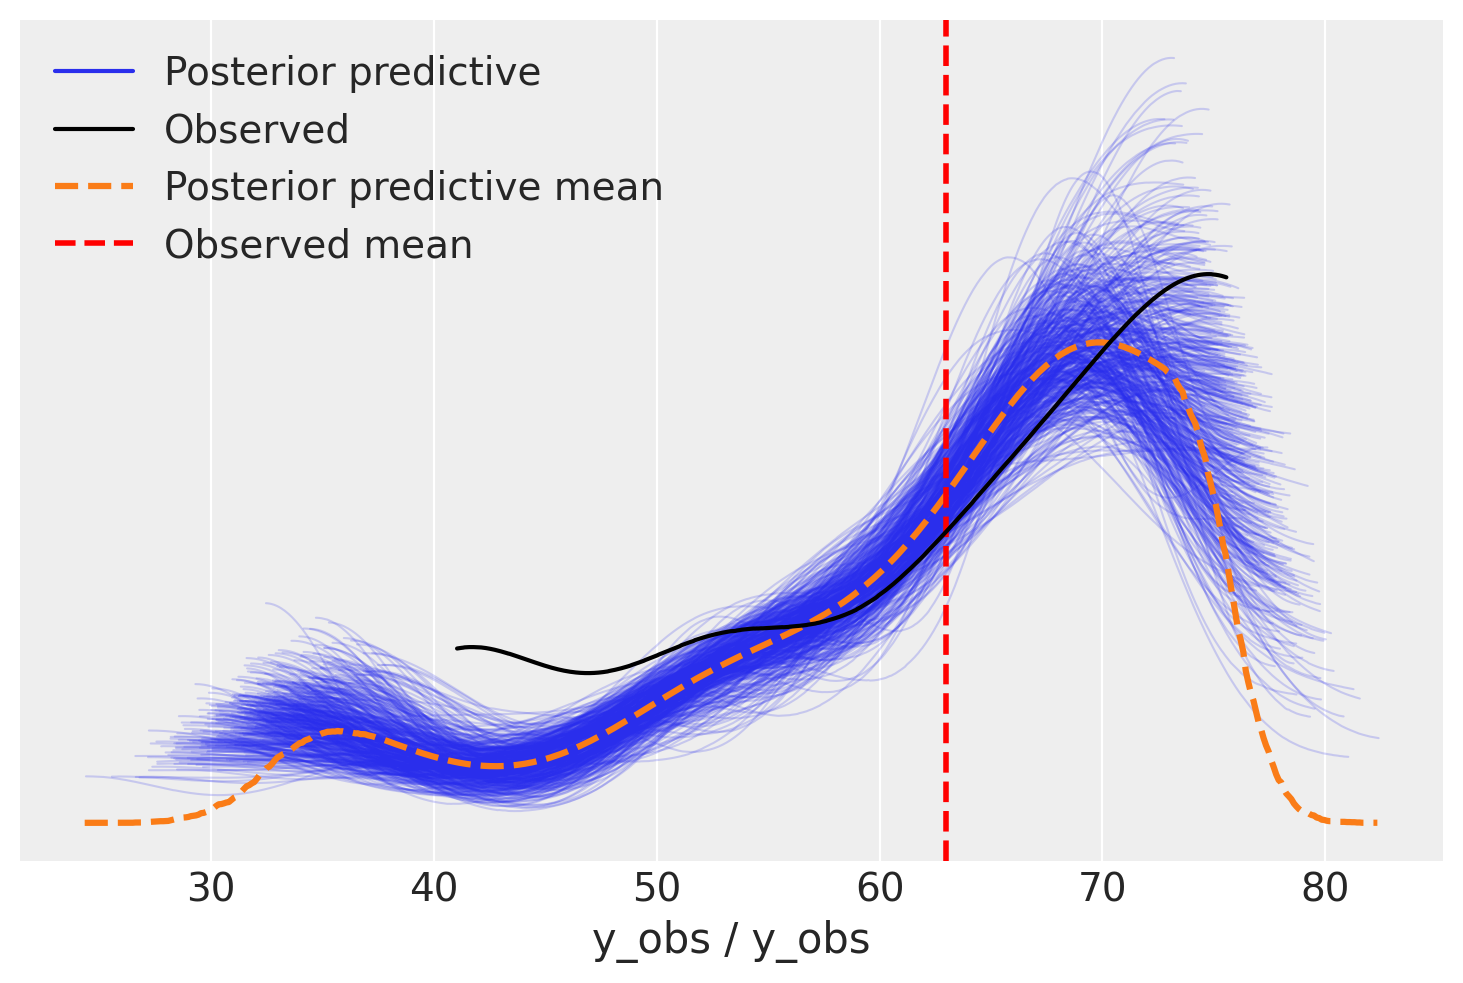

In [81]:
# -- Generate and plot posterior predictive samples from X_test

model_test = make_model(p_hat, g, eta, X_test, Y_test, theta_names,
                        theta_names_aux[:1], mle_theta)

with model_test:
    print("Generating posterior predictive on hold-out data...")
    ppc_test = pm.sample_posterior_predictive(idata_pymc)

utils.plot_ppc(
    az.from_pymc3(posterior_predictive=ppc_test, model=model_test),
    n_samples=500,
    data_pairs={'y_obs': 'y_obs'})

Next we look at the MSE when using several point-estimates for the parameters.

In [82]:
# -- Compute metrics using several point estimates

point_estimates = ["mode", "mean", "median"]

df_metrics_pymc = pd.DataFrame(columns=results_columns)

for i, pe in enumerate(point_estimates):
    Y_hat = utils.point_predict(
        X_test, idata_pymc,
        theta_names, pe)
    metrics = utils.regression_metrics(Y_test, Y_hat)
    df_metrics_pymc.loc[i] = [
        "pymc_" + pe,
        p_hat,
        metrics["mse"],
        np.sqrt(metrics["mse"]),
        metrics["r2"]
    ]

df_metrics_pymc = df_metrics_pymc.append(df_metrics_sk)
df_metrics_pymc.sort_values(results_columns[-2], inplace=True)
df_metrics_pymc.style.hide_index()

### Save & Load

In [ ]:
# -- Save

_ = idata_pymc.to_netcdf("pymc-p-fixed.nc")

In [ ]:
# -- Load

idata_pymc = az.from_netcdf("pymc-p-fixed.nc")

## Notebook metadata

In [45]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Thu Nov 18 2021

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 7.28.0

pandas    : 1.3.3
theano    : 1.1.2
emcee     : 3.1.1
matplotlib: 3.4.3
json      : 2.0.9
pymc3     : 3.11.4
numpy     : 1.20.3
autopep8  : 1.5.7
scipy     : 1.7.1
skfda     : 0.0
sys       : 3.9.7 (default, Oct 10 2021, 15:13:22) 
[GCC 11.1.0]
arviz     : 0.11.4
logging   : 0.5.1.2

Watermark: 2.2.0

